<h1 align="center">Taxi Demand Prediction</h1>


<img src="https://www.peoplesworld.org/wp-content/uploads/2017/08/taxisinnewyork960.jpg" alt="Drawing" style="width: 1000px; height: 350px"/>


# Introduction



With the rise of taxi services such as Ola and Uber, commuting in urban areas has become more convenient than ever. It has also created a lot of jobs for people. Now, the earning capacity of a driver depends a lot on the number of pickups he makes per day. It is essential for the driver as well as the cab company to know the demand for a cab in a given region at a given time. This will help not only in optimizing the income of taxi drivers but also in judicious distribution of taxis so that the demand matches the supply.

## Objective

The objective of this study is to predict in a time bound manner the possible pickups in a region so that a driver can decide whether to stay in the area or move to a different location in order to increase the possibility of a pickup.

## Data

The [New York City Taxi and Limousine Commission](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) has made available a large quantity of data about Yellow taxi trips in the city of New York for the last several years, segregated into months. It contains data such as pickup & drop-off latitudes-longitudes, fare amount, tip amount, distance etc. among other things. 

![title](http://www.nyc.gov/html/tlc/images/features/fi_about_photo_trip_records.png)

I have chosen the data of __July__ and __August__ __2015__ for this study. We will predict the number of pickups in the last week of August based on the data of July and twenty-three days of August. In the following sections, we will learn more about this fascinating dataset. We will then clean it, massage it into the form that we need and develop some models to predict the number of pickups with reasonable accuracy. Let's begin by importing the libraries we need!

In [1]:
import pandas as pd
import folium
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import gpxpy.geo
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
from geopy import distance
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import r2_score
from prettytable import PrettyTable
import geopandas as gpd

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

Set figure parameters

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,5)
plt.style.use('bmh')

## Understanding the Geography

New York City is divided into 5 boroughs, namely - Manhattan, Bronx, Staten Island, Brooklyn and Queens. Following is a map of NYC. It is located between the longitude [-74.15, -73.7004] and Latitude [40.5774, 40.9176].

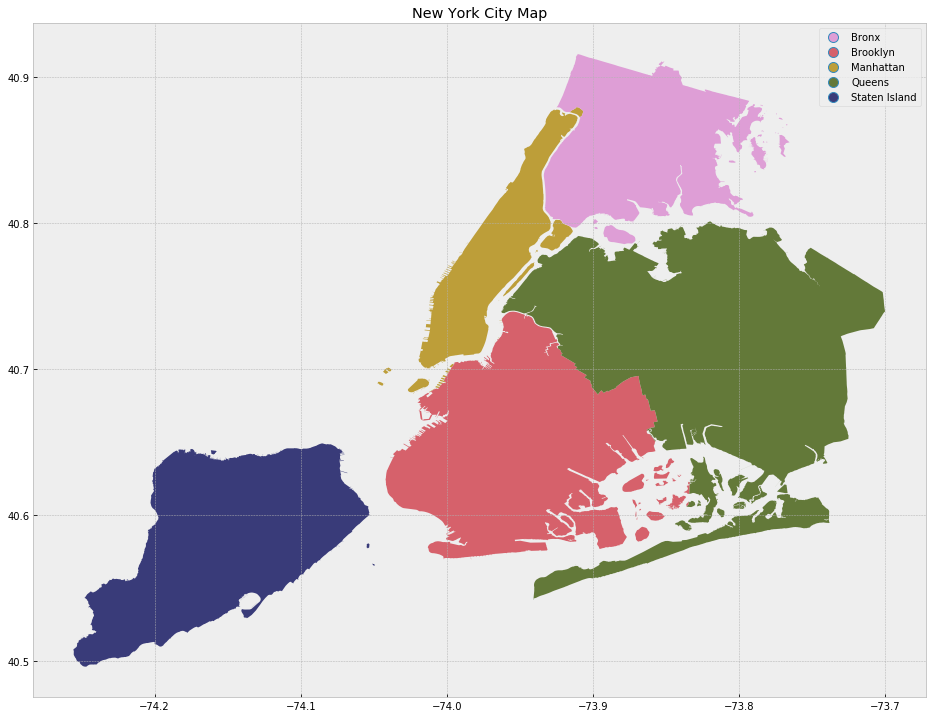

In [4]:
# Read the GeoJson file using GeoPandas and plot the map 
# GeoJson file available at:
url='http://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/nybb/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=geojson'
taxi_zones_shapes = gpd.read_file(url)
rcParams['figure.figsize'] = (16,16)
taxi_zones_shapes.plot(column='BoroName', legend=True, cmap='tab20b_r')
_ = plt.title('New York City Map')

## First look at the data

You can find here the data for [July 2015](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-07.csv) and [August 2015](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-08.csv). These are not lightweight CSV files, each of them being ~1.7 GB. I've downloaded them on my disk. Let's load them one by one and see what kind of data they have.

In [4]:
df_jul15 = pd.read_csv('/home/ucanreachtvk/data/taxi_data/yellow_tripdata_2015-07.csv', parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'], index_col=['tpep_pickup_datetime','tpep_dropoff_datetime'])
df_jul15.head()

VendorID  passenger_count  \
tpep_pickup_datetime tpep_dropoff_datetime                              
2015-07-01           2015-07-01 00:15:26           1                1   
                     2015-07-01 00:22:22           1                1   
                     2015-07-01 00:07:42           1                1   
                     2015-07-01 00:39:37           1                1   
                     2015-07-01 00:05:34           1                1   

                                            trip_distance  pickup_longitude  \
tpep_pickup_datetime tpep_dropoff_datetime                                    
2015-07-01           2015-07-01 00:15:26              3.5        -73.994156   
                     2015-07-01 00:22:22              3.9        -73.984657   
                     2015-07-01 00:07:42              2.3        -73.978889   
                     2015-07-01 00:39:37              9.2        -73.992790   
                     2015-07-01 00:05:34              1.1        -73.912430   

                                            pickup_latitude  RatecodeID  \
tpep_pickup_datetime tpep_dropoff_datetime                                
2015-07-01           2015-07-01 00:15:26          40.751125           1   
                     2015-07-01 00:22:22          40.768486           1   
                     2015-07-01 00:07:42          40.762287           1   
                     2015-07-01 00:39:37          40.742760           1   
                     2015-07-01 00:05:34          40.769810           1   

                                           store_and_fwd_flag  \
tpep_pickup_datetime tpep_dropoff_datetime                      
2015-07-01           2015-07-01 00:15:26                    N   
                     2015-07-01 00:22:22                    N   
                     2015-07-01 00:07:42                    N   
                     2015-07-01 00:39:37                    N   
                     2015-07-01 00:05:34                    N   

                                            dropoff_longitude  \
tpep_pickup_datetime tpep_dropoff_datetime                      
2015-07-01           2015-07-01 00:15:26           -73.976822   
                     2015-07-01 00:22:22           -74.000130   
                     2015-07-01 00:07:42           -74.004219   
                     2015-07-01 00:39:37           -73.971512   
                     2015-07-01 00:05:34           -73.920334   

                                            dropoff_latitude  payment_type  \
tpep_pickup_datetime tpep_dropoff_datetime                                   
2015-07-01           2015-07-01 00:15:26           40.788567             2   
                     2015-07-01 00:22:22           40.734898             2   
                     2015-07-01 00:07:42           40.752533             2   
                     2015-07-01 00:39:37           40.637154             1   
                     2015-07-01 00:05:34           40.757442             1   

                                            fare_amount  extra  mta_tax  \
tpep_pickup_datetime tpep_dropoff_datetime                                
2015-07-01           2015-07-01 00:15:26           14.0    0.5      0.5   
                     2015-07-01 00:22:22           17.0    0.5      0.5   
                     2015-07-01 00:07:42            9.0    0.5      0.5   
                     2015-07-01 00:39:37           33.0    0.5      0.5   
                     2015-07-01 00:05:34            6.0    0.5      0.5   

                                            tip_amount  tolls_amount  \
tpep_pickup_datetime tpep_dropoff_datetime                             
2015-07-01           2015-07-01 00:15:26          0.00           0.0   
                     2015-07-01 00:22:22          0.00           0.0   
                     2015-07-01 00:07:42          0.00           0.0   
                     2015-07-01 00:39:37          8.55           0.0   
                     2015-07-01 00:

Let's look at the columns of this dataframe

In [5]:
df_jul15.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

As you can see above, this is a very informative dataset containing data about multiple important facets. Here's an explanation of some of the columns which aren't too obvious:

1. **VendorID**

    
    A code indicating the TPEP provider that provided the record.
    
    1= Creative Mobile Technologies, LLC;
    
    2= VeriFone Inc.

    T-PEP stands for "Taxicab Passenger Enhancements Project"
    It focuses on four areas: automated collection and submission of trip data, the installation of a passenger information monitor (including a passenger information map), incorporating electronic message transmission capability into the taxicab, and finally, the addition of equipment to enable the acceptance of credit/debit cards.

2. **RatecodeID**
    
    The final rate code in effect at the end of the trip.
        1= Standard rate
        2=JFK
        3=Newark
        4=Nassau or Westchester
        5=Negotiated fare
        6=Group ride
3. **store_and_fwd_flag**

        This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip N= not a store and forward trip.
4. **MTA Tax**

        $0.50 MTA tax that is automatically triggered based on the metered rate in use.
        
5. **Improvement Surcharge**
        $0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.


With July 2015, load the data of August 2015 too. It has the exact same column structure.

In [6]:
df_aug15 = pd.read_csv('/home/ucanreachtvk/data/taxi_data/yellow_tripdata_2015-08.csv', parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'], index_col=['tpep_pickup_datetime','tpep_dropoff_datetime'])

The shape of both the files

In [7]:
df_jul15.shape, df_aug15.shape

((11562783, 17), (11130304, 17))

Each row corresponds to a trip record. The `.shape[0]` attribute stores the number of records in that dataframe. Looks like July had more number of trips than August.

In [8]:
df_aug15.shape[0] - df_jul15.shape[0]

-432479

Let's combine the two frames and see their content. As expected, the last few rows belong to August 2015. The first few belong to July 2015.

In [9]:
df_jul_aug_2015 = pd.concat([df_jul15, df_aug15])

In [10]:
df_jul_aug_2015.head()

VendorID  passenger_count  \
tpep_pickup_datetime tpep_dropoff_datetime                              
2015-07-01           2015-07-01 00:15:26           1                1   
                     2015-07-01 00:22:22           1                1   
                     2015-07-01 00:07:42           1                1   
                     2015-07-01 00:39:37           1                1   
                     2015-07-01 00:05:34           1                1   

                                            trip_distance  pickup_longitude  \
tpep_pickup_datetime tpep_dropoff_datetime                                    
2015-07-01           2015-07-01 00:15:26              3.5        -73.994156   
                     2015-07-01 00:22:22              3.9        -73.984657   
                     2015-07-01 00:07:42              2.3        -73.978889   
                     2015-07-01 00:39:37              9.2        -73.992790   
                     2015-07-01 00:05:34              1.1        -73.912430   

                                            pickup_latitude  RatecodeID  \
tpep_pickup_datetime tpep_dropoff_datetime                                
2015-07-01           2015-07-01 00:15:26          40.751125           1   
                     2015-07-01 00:22:22          40.768486           1   
                     2015-07-01 00:07:42          40.762287           1   
                     2015-07-01 00:39:37          40.742760           1   
                     2015-07-01 00:05:34          40.769810           1   

                                           store_and_fwd_flag  \
tpep_pickup_datetime tpep_dropoff_datetime                      
2015-07-01           2015-07-01 00:15:26                    N   
                     2015-07-01 00:22:22                    N   
                     2015-07-01 00:07:42                    N   
                     2015-07-01 00:39:37                    N   
                     2015-07-01 00:05:34                    N   

                                            dropoff_longitude  \
tpep_pickup_datetime tpep_dropoff_datetime                      
2015-07-01           2015-07-01 00:15:26           -73.976822   
                     2015-07-01 00:22:22           -74.000130   
                     2015-07-01 00:07:42           -74.004219   
                     2015-07-01 00:39:37           -73.971512   
                     2015-07-01 00:05:34           -73.920334   

                                            dropoff_latitude  payment_type  \
tpep_pickup_datetime tpep_dropoff_datetime                                   
2015-07-01           2015-07-01 00:15:26           40.788567             2   
                     2015-07-01 00:22:22           40.734898             2   
                     2015-07-01 00:07:42           40.752533             2   
                     2015-07-01 00:39:37           40.637154             1   
                     2015-07-01 00:05:34           40.757442             1   

                                            fare_amount  extra  mta_tax  \
tpep_pickup_datetime tpep_dropoff_datetime                                
2015-07-01           2015-07-01 00:15:26           14.0    0.5      0.5   
                     2015-07-01 00:22:22           17.0    0.5      0.5   
                     2015-07-01 00:07:42            9.0    0.5      0.5   
                     2015-07-01 00:39:37           33.0    0.5      0.5   
                     2015-07-01 00:05:34            6.0    0.5      0.5   

                                            tip_amount  tolls_amount  \
tpep_pickup_datetime tpep_dropoff_datetime                             
2015-07-01           2015-07-01 00:15:26          0.00           0.0   
                     2015-07-01 00:22:22          0.00           0.0   
                     2015-07-01 00:07:42          0.00           0.0   
                     2015-07-01 00:39:37          8.55           0.0   
                     2015-07-01 00:

In [11]:
df_jul_aug_2015.tail()

,,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
tpep_pickup_datetime,tpep_dropoff_datetime,,,,,,,,,,,,,,,,,
2015-08-31 16:55:28,2015-08-31 16:59:41,1,1,0.8,-73.989830,40.756512,1,Y,-73.983727,40.766338,1,5.0,0.0,0.5,1.16,0.0,0.3,6.96
2015-08-31 17:08:23,2015-08-31 17:13:46,1,3,0.7,-73.981224,40.778446,1,Y,-73.989182,40.773251,1,5.5,0.0,0.5,1.26,0.0,0.3,7.56
2015-08-31 17:16:05,2015-08-31 17:33:03,1,1,1.5,-73.989555,40.771923,1,N,-73.978546,40.757195,1,11.5,0.0,0.5,2.46,0.0,0.3,14.76
2015-08-31 17:48:57,2015-08-31 17:52:09,1,1,0.6,-73.965958,40.771362,1,N,-73.959953,40.778214,1,4.5,0.0,0.5,1.32,0.0,0.3,6.62
2015-08-31 17:57:38,2015-08-31 18:04:50,1,1,1.0,-73.959023,40.781059,1,Y,-73.972244,40.781406,2,6.5,0.0,0.5,0.00,0.0,0.3,7.30


Let's see some information on this dataframe. It's a huge file of 3.1 GB, with a datetime Multi-index. There are ~22.69 million trip records.

In [13]:
df_jul_aug_2015.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 22693087 entries, (2015-07-01 00:00:00, 2015-07-01 00:15:26) to (2015-08-31 17:57:38, 2015-08-31 18:04:50)
Data columns (total 17 columns):
VendorID                 int64
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: float64(12), int64(4), object(1)
memory usage: 3.1+ GB


### Datetime in Unix seconds

We have pickup and drop-off times like 

> 2015-08-31 17:08:23

which are in `timestamp` format. Convert them into Unix seconds which will make it very simple for us to create some new features based on time. We'll take advantage of Pandas' *vectorized index operations* which are extremely fast, to convert the datetimes into Unix seconds.

In [16]:
df_jul_aug_2015.index = pd.MultiIndex.from_arrays([df_jul_aug_2015.index.get_level_values(0).astype(np.int64)//10**9, \
                                                   df_jul_aug_2015.index.get_level_values(1).astype(np.int64)//10**9])
df_jul_aug_2015.reset_index(inplace=True)

Let's see how the dataframe looks now

In [17]:
df_jul_aug_2015.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1435708800,1435709726,1,1,3.5,-73.994156,40.751125,1,N,-73.976822,40.788567,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30
1,1435708800,1435710142,1,1,3.9,-73.984657,40.768486,1,N,-74.000130,40.734898,2,17.0,0.5,0.5,0.00,0.0,0.3,18.30
2,1435708800,1435709262,1,1,2.3,-73.978889,40.762287,1,N,-74.004219,40.752533,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30
3,1435708800,1435711177,1,1,9.2,-73.992790,40.742760,1,N,-73.971512,40.637154,1,33.0,0.5,0.5,8.55,0.0,0.3,42.85
4,1435708800,1435709134,1,1,1.1,-73.912430,40.769810,1,N,-73.920334,40.757442,1,6.0,0.5,0.5,2.00,0.0,0.3,9.30


The timestamps have been converted into seconds. It would be just as easy to convert them back into the original format using Pandas. We'll do that after the initial analysis is done.

Let's save the total number of records present in the file. When we clean the data, some of it will have to be discarded.

In [18]:
records_before_cleaning = df_jul_aug_2015.shape[0]

In [19]:
records_before_cleaning

22693087

# Univariate Analysis 

Let's do some Exploratory Data Analysis (EDA). It will help us get the *feel* of the data.

There are a lot of features in this dataframe. We analyze and clean them one by one. We will also create a couple of new features called `trip_duration` and `speed` which will help us in detecting erroneous data. For each feature of importance, we will remove erroneous data points as well as extreme outliers.

I'll first define a couple of functions which will be very helpful during the EDA.

1. cdf 
        It returns the x and y limits for the cumulative distribution function
2. plot_eda
        It plots three graphs: a CDF, a distribution plot and a Box Plot of the real valued feature passed to it

In [20]:
def cdf(data):
    """
    compute ECDF for a one dimensional array of measurements.
    The y data of the ECDF go from 1/n to 1 in equally spaced increments.
    the end value in np.arange() is not inclusive. Therefore, np.arange() will need to go from 1 to n+1
    """
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1) / n
    return x,y

In [21]:
def plot_eda(values, title, xlabel, hist_bins=100):
    
    x, y = cdf(values)

    plt.subplot(1,3,1)
    plt.grid()
    plt.plot(x, y, marker='.', linestyle='none', markersize=1)
    plt.margins(0.05)
    _ = plt.xlabel(xlabel, fontsize=14)
    _ = plt.ylabel('CDF', fontsize=14)
    _ = plt.title('CDF of '+ title, fontsize=16)

    plt.subplot(1,3,2)
    sbn.distplot(values)
    plt.xlabel('bins', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution plot of '+title, fontsize=16)
    plt.grid()
    
    plt.subplot(1,3,3)    
    sbn.boxplot(values, orient='h')
    plt.title('Boxplot of ' + title, fontsize=16)
    
    plt.tight_layout()
    plt.grid()
    plt.show()

## 1. Trip duration(seconds)

We'll create this new feature from pickup and dropoff datetimes.

In [22]:
df_jul_aug_2015['trip_duration'] = df_jul_aug_2015['tpep_dropoff_datetime'] - df_jul_aug_2015['tpep_pickup_datetime']

A few samples of the newly constructed column - trip_duration

In [23]:
df_jul_aug_2015[['tpep_pickup_datetime','tpep_dropoff_datetime','trip_duration']].sample(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration
4897997,1436905726,1436906198,472
11123770,1438295040,1438295578,538
6489121,1437254391,1437254954,563
12224780,1439879536,1439880002,466
4531835,1436820121,1436822247,2126
16345286,1440759134,1440761299,2165
6636051,1437282272,1437283538,1266
16980893,1440943009,1440944762,1753
5123984,1436961256,1436962109,853
773015,1435885711,1435888021,2310


Time to filter out erroneous data! i.e. records where trip duration is less than or equal to 0. That's right. There are records where Trip duration is **negative**! See them in the table below...

In [24]:
# Create a boolean series where trip duration is negative or zero
invalid_trip_duration = df_jul_aug_2015['trip_duration'] < 0
#filter such records
df_jul_aug_2015[invalid_trip_duration][['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_duration']].sample(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration
18626076,1440015564,1440015492,-72
15774796,1440627496,1440627388,-108
410250,1435800736,1435800637,-99
21972694,1439550226,1439549710,-516
15512325,1440578007,1440577973,-34
8067838,1437606553,1437606461,-92
6589046,1437270156,1437270119,-37
19453536,1438969786,1438969752,-34
18932733,1440092800,1440092768,-32
13805582,1440161525,1440161411,-114


Drop such records

In [25]:
invalid_trip_duration = df_jul_aug_2015['trip_duration'] <= 0
df_jul_aug_2015.drop(df_jul_aug_2015[invalid_trip_duration].index, inplace=True)

**Outlier trip durations**

Now, let's remove extreme outliers. For each feature, I'll try to remove the values which are beyond **99.99** percentile. This is a very safe threshold to assume that dropping some data will not have any adverse effect on our analysis. The 99.99 percentile value for `trip_duration` is 1437 minuts, which is ~24 hours. It's an absurdly long trip duration!

Let's try the 99.90 percentile value, which seems more reasonable. We'll convert it into seconds and remove all records with values greater than it.

In [26]:
# Find trip duration in minutes.
trip_durations_minutes = df_jul_aug_2015['trip_duration'] // 60
np.percentile(trip_durations_minutes, 99.99)

1437.0

In [27]:
np.percentile(trip_durations_minutes, 99.90)

117.0

Convert minutes to seconds and drop these values

In [28]:
# 117*60 = 7020
outlier_trip_durations = df_jul_aug_2015.trip_duration > 7020
df_jul_aug_2015.drop(df_jul_aug_2015[outlier_trip_durations].index, inplace=True)

**EDA on trip_durations**

We will plot a Cumulative Distribution Function (CDF), distribution plot and a BoxPlot to analyze the trip duration. Let's calculate trip duration minutes again after removing outliers and pass it to the function we defined above. As you can see in the graphs below, about 99% of the trips have a trip duration of ~30 minutes, which is what we'd expect. 

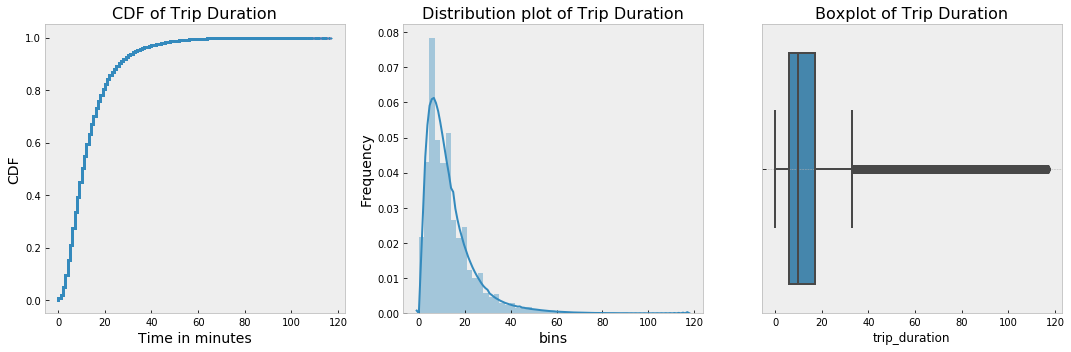

In [30]:
trip_durations_minutes = df_jul_aug_2015.trip_duration // 60
plot_eda(trip_durations_minutes, title='Trip Duration', xlabel='Time in minutes', hist_bins=50)

## 2 : Trip Distance

The 99.99 percentile value of distance is ~39.80 **miles**. Remove all the records beyond this value. 

In [31]:
np.percentile(df_jul_aug_2015.trip_distance, 99.99)

39.8

In [32]:
outlier_trip_distances = df_jul_aug_2015.trip_distance > 39.8
df_jul_aug_2015.drop(df_jul_aug_2015[outlier_trip_distances].index, inplace=True)

**EDA on Trip distances**

Like for trip duration, plot the CDF, distribution plot and the box plot.
Notice that most of the trips have a distance less than 10 miles.

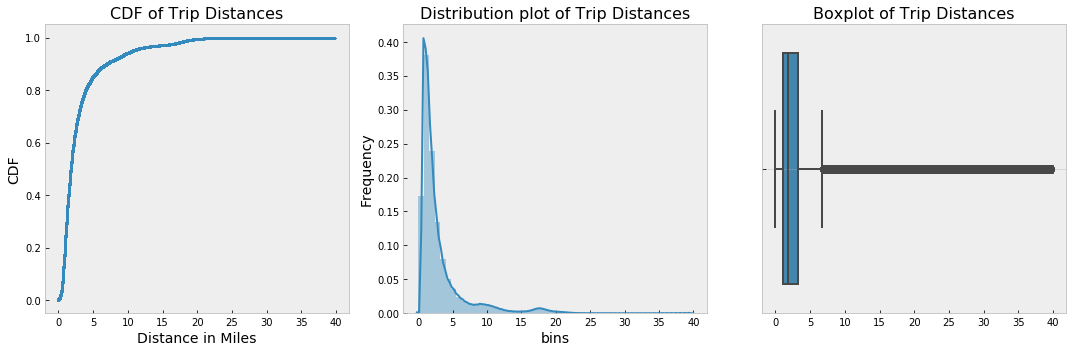

In [34]:
plot_eda(df_jul_aug_2015.trip_distance.values, title='Trip Distances', xlabel='Distance in Miles', hist_bins=100)

## 3. Speed (miles/hour)

We have distance and time. Let's create a new feature Speed during the trip which is Distance of trip/Time of trip

In [35]:
df_jul_aug_2015['speed'] = (df_jul_aug_2015['trip_distance']/df_jul_aug_2015['trip_duration']) * 60 * 60

The 99.99 percentile value of Speed is 4440 miles/hour which is just insane! The fastest bullet train in the world, the **Shanghai Maglev** has a top speed of just 267 miles/hour! NYC must have some superhuman drivers to drive at 4440 mph. Let's avoid them for now by limiting this feature to 99.9 percentile which is a more reasonable value of 50.43 miles/hour.

In [36]:
np.percentile(df_jul_aug_2015['speed'], 99.99)

4440.0

In [37]:
np.percentile(df_jul_aug_2015['speed'], 99.9)

50.426514470390266

Drop the extreme outliers.

In [38]:
outlier_speeds = df_jul_aug_2015.speed > 51
df_jul_aug_2015.drop(df_jul_aug_2015[outlier_speeds].index, inplace=True)

**EDA: Speed**

It looks like the taxis generally have a speed between 10-30 miles/hour which is understandable given than NYC is a crowded place especially during the evening hours.

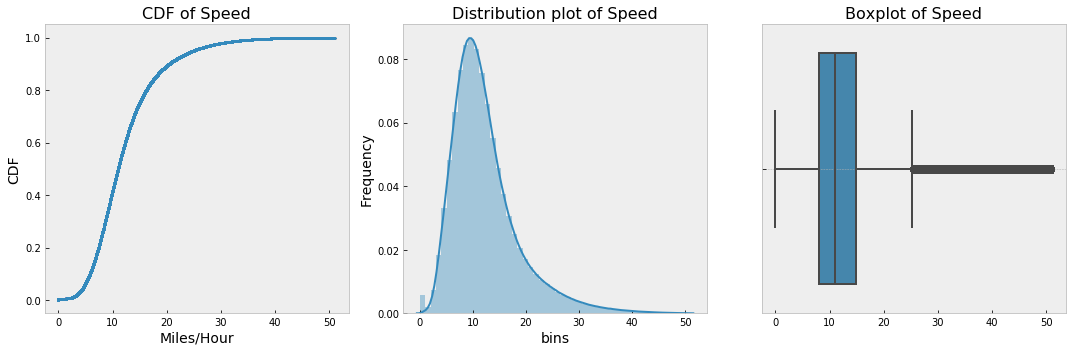

In [39]:
plot_eda(df_jul_aug_2015.speed.values, title='Speed', xlabel='Miles/Hour', hist_bins=100)

### 4. VendorID

VendorID indicates who provided the record.

Recall that 

        Vendor 1= Creative Mobile Technologies, LLC 
        Vendor 2= VeriFone Inc.

Vendor 2 is more in number although the difference is not very large.

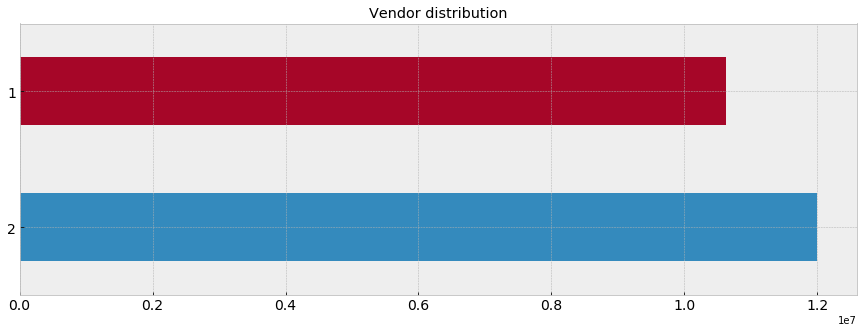

In [40]:
_ = df_jul_aug_2015.VendorID.value_counts().plot(kind='barh', title='Vendor distribution', fontsize=14)

## 5. Number of passengers

Generally, how many passengers are there in a trip? Do people tend to travel in groups or alone?

Looking at the CDF below, we notice that in most of the trips, people travel alone. Although there have been instances where there were upto 8 people in a cab! 

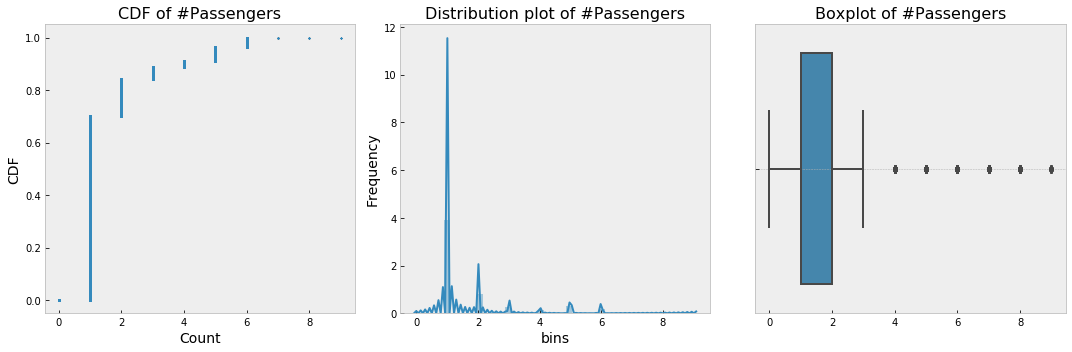

In [41]:
plot_eda(df_jul_aug_2015.passenger_count.values, title='#Passengers', xlabel='Count', hist_bins=100)

## 6. Fare amount

There are records where the fare amount too is negative.
 Here are a few of them. Notice the `fare_amount` column by scrolling the dataframe to the right.

In [42]:
df_jul_aug_2015[df_jul_aug_2015.fare_amount < 0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed
368,1435708882,1435708885,2,1,0.00,0.000000,0.000000,5,N,0.000000,...,4,-60.0,0.0,-0.5,0.0,0.0,-0.3,-60.8,3,0.000000
799,1435709048,1435709428,2,1,0.00,0.000000,0.000000,5,N,0.000000,...,3,-70.0,0.0,-0.5,0.0,0.0,-0.3,-70.8,380,0.000000
958,1435709087,1435709128,2,6,0.18,-73.967659,40.756191,1,N,-73.966278,...,3,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,41,15.804878
1899,1435708960,1435709060,2,1,0.06,-73.959152,40.767891,1,N,-73.961937,...,3,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,100,2.160000
2434,1435709350,1435709683,2,1,0.97,-73.990273,40.740528,1,N,-73.976501,...,4,-6.0,-0.5,-0.5,0.0,0.0,-0.3,-7.3,333,10.486486


Let's drop such invalid records

In [43]:
invalid_fair_amounts = df_jul_aug_2015.fare_amount < 0
df_jul_aug_2015.drop(df_jul_aug_2015[invalid_fair_amounts].index, inplace=True)

**Extreme Outliers**

The 99.99 percentile value of fare amount is $165. Remove all the records which are beyond that. 

In [44]:
np.percentile(df_jul_aug_2015.fare_amount, 99.99)

165.0

In [45]:
outlier_fair_amounts = df_jul_aug_2015.fare_amount > 165
df_jul_aug_2015.drop(df_jul_aug_2015[outlier_fair_amounts].index, inplace=True)

**EDA: Fare Amount**

Looks like generally the fare is between 0 to 50 dollars, although there have been people who've paid upto $175. That's an insane amount of money to spend on a single taxi trip!

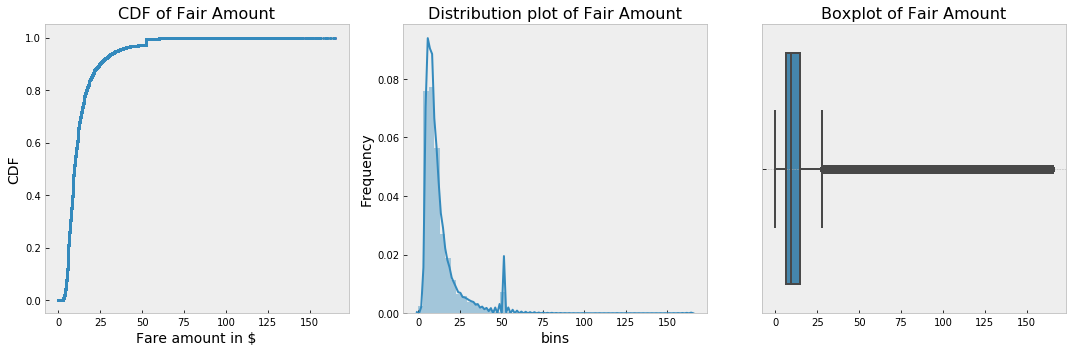

In [46]:
plot_eda(df_jul_aug_2015.fare_amount.values, title='Fair Amount', xlabel='Fare amount in $', hist_bins=100)

## 7. Tip Amount

How do passengers tip their drivers? Before trying to answer this question, again, let's remove erroneous data (<0) and extreme outliers. 

Observe the tip_amount column in the dataframe below by scrolling it to the right. These are records where tip amount is negative.

In [47]:
invalid_tip_amounts = df_jul_aug_2015.tip_amount < 0
df_jul_aug_2015[invalid_tip_amounts]

,tpep_pickup_datetime,tpep_dropoff_datetime,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed
11560760,1437752160,1437752400,2,1,0.0,0.000000,0.000000,1,N,0.000000,...,1,2.50,0.0,0.00,-0.01,0.0,0.0,2.49,240,0.0
11560954,1437650700,1437650940,2,1,0.0,0.000000,0.000000,1,N,0.000000,...,1,4.30,0.0,0.50,-0.01,0.0,0.0,4.79,240,0.0
11560983,1437657060,1437658560,2,1,0.0,0.000000,0.000000,1,N,0.000000,...,1,3.50,0.0,0.50,-0.01,0.0,0.0,3.99,1500,0.0
11561047,1437721980,1437722040,2,1,0.3,0.000000,0.000000,1,N,0.000000,...,1,4.30,0.0,0.50,-0.01,0.0,0.0,4.79,60,18.0
11561415,1436956380,1436956800,2,1,0.0,-73.981522,40.768200,1,N,-73.981522,...,1,3.00,0.0,0.40,-0.01,0.0,0.0,3.39,420,0.0
11561476,1436981220,1436981520,2,1,0.0,0.000000,0.000000,1,N,0.000000,...,1,2.50,0.0,0.00,-0.01,0.0,0.0,2.49,300,0.0
11561532,1437046500,1437046680,2,1,0.0,-73.937294,40.764709,1,N,-73.937485,...,1,2.30,0.0,0.25,-0.01,0.0,0.0,2.54,180,0.0
12034457,1439824560,1439824620,2,1,0.0,-73.937202,40.764744,1,N,-73.937202,...,1,3.25,0.0,0.00,-0.01,0.0,0.0,3.24,60,0.0
17685364,1438766640,1438766700,2,1,0.1,0.000000,0.000000,1,N,0.000000,...,1,3.50,0.0,3.00,-0.01,0.0,0.0,6.49,60,6.0
17795160,1438785960,1438786020,2,1,0.0,0.000000,0.000000,1,N,0.000000,...,1,3.50,0.0,3.00,-0.01,0.0,0.0,6.49,60,0.0


In [48]:
df_jul_aug_2015.drop(df_jul_aug_2015[invalid_tip_amounts].index, inplace=True)

**Extreme Outliers**

The 99.99 percentile of tip amount is $45. We'll remove all records beyond that.

In [49]:
np.percentile(df_jul_aug_2015.tip_amount, 99.99)

45.0

In [50]:
outlier_tip_amounts = df_jul_aug_2015.tip_amount > 45
df_jul_aug_2015.drop(df_jul_aug_2015[outlier_tip_amounts].index, inplace=True)

**EDA: Tip Amount**

So generally passengers tip between 0 to 5 dollars. But some people have given their drivers tips more than $45. That's so generous! I wonder what was so special about those trips?!

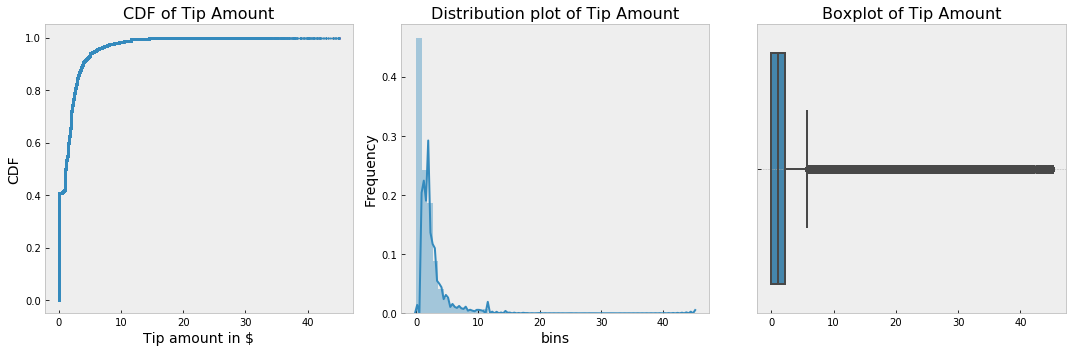

In [51]:
plot_eda(df_jul_aug_2015.tip_amount.values, title='Tip Amount', xlabel='Tip amount in $', hist_bins=75)

## 8. Toll Amount

Nobody likes to pay tolls. But sometimes, there's no escaping it. Are there any records with negative toll values? No, but there definitely are outliers.

In [52]:
invalid_toll_amounts = df_jul_aug_2015.tolls_amount < 0
df_jul_aug_2015[invalid_toll_amounts]

,tpep_pickup_datetime,tpep_dropoff_datetime,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed


The 99.99 percentile value of toll amount is $20.83. Let's drop values beyond that.

In [53]:
np.percentile(df_jul_aug_2015.tolls_amount, 99.99)

20.54

In [54]:
outlier_toll_amounts = df_jul_aug_2015.tolls_amount > 20.54
df_jul_aug_2015.drop(df_jul_aug_2015[outlier_toll_amounts].index, inplace=True)

**EDA: Toll Amount**

Looks like people usually don't have to pay any toll. That's understandable, because you generally pay it only while entering a new territory. But since most of the dropoffs are within NYC, paying a toll must not be necessary. But there have been instances where people have paid a toll of more than $20. So unlucky!  

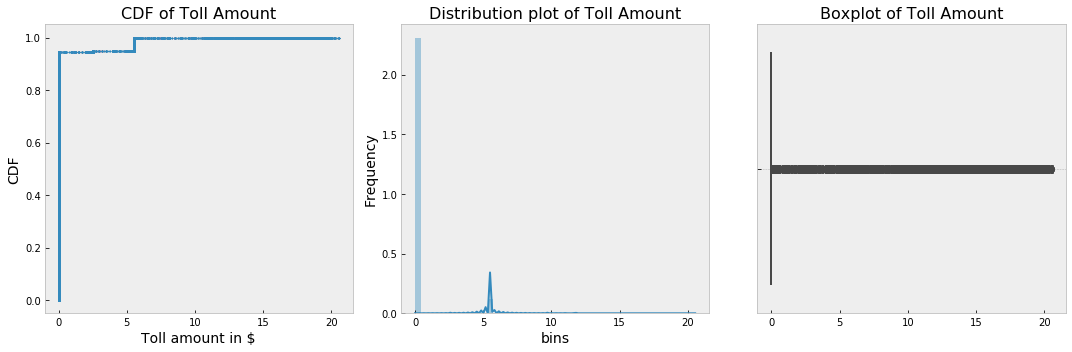

In [56]:
plot_eda(df_jul_aug_2015.tolls_amount.values, title='Toll Amount', xlabel='Toll amount in $', hist_bins=100)

## 9. Total Amount

Total amount is the sum of all - the actual fare amount, tolls and other fixed taxes. Are there any absurd records with negative total amount? No, but there are extreme outliers.

In [57]:
invalid_total_amounts = df_jul_aug_2015.total_amount < 0
df_jul_aug_2015[invalid_total_amounts]

,tpep_pickup_datetime,tpep_dropoff_datetime,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed


The 99.99 percentile value of Total amount is ~ $155.3. Remove values beyond that.

In [58]:
np.percentile(df_jul_aug_2015.total_amount, 99.99)

155.3

In [59]:
outlier_total_amount = df_jul_aug_2015.total_amount > 155.3
df_jul_aug_2015.drop(df_jul_aug_2015[outlier_total_amount].index, inplace=True)

**EDA: Total Amount**

Total amount is generally between 0 to 40 dollars, which sounds reasonable.

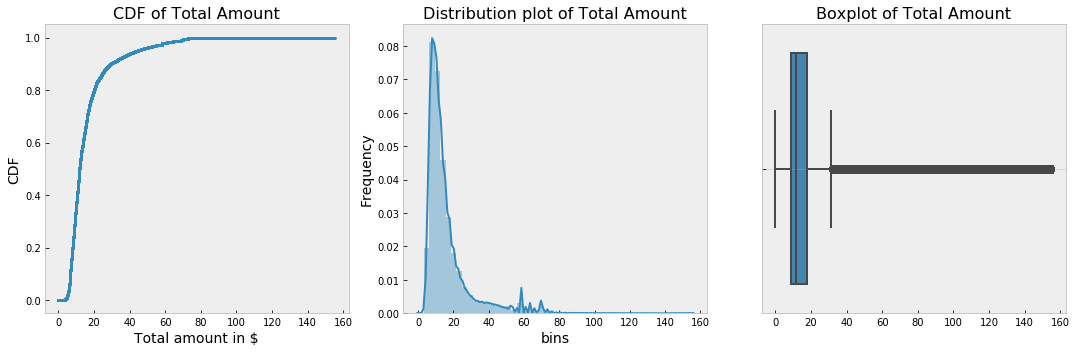

In [60]:
plot_eda(df_jul_aug_2015.total_amount.values, title='Total Amount', xlabel='Total amount in $', hist_bins=100)

### 10. Payment Type

What mode of payment is preferred by the passengers?

In our data, the payment type is a categorical feature with a numeric code signifying how the passenger paid for the trip.

        1 = Credit card
        2 = Cash
        3 = No charge
        4 = Dispute


Looking at the bar chart below, it seems a Credit card is the most preferred mode of payment, followed by Cash. Modes 3 and 4 indicate special situations which are rarely encountered.

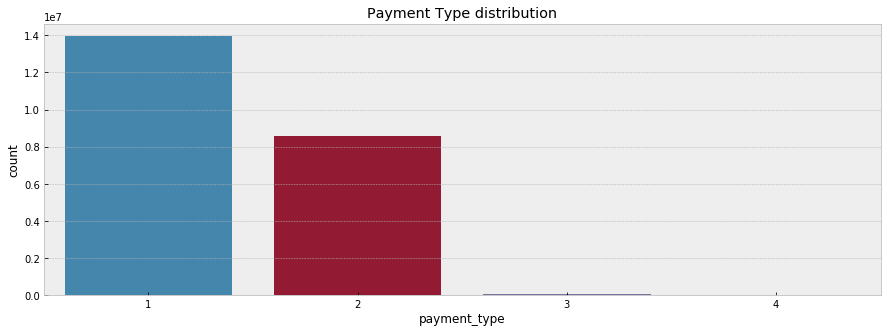

In [62]:
_ = sbn.countplot(data=df_jul_aug_2015, x='payment_type')
plt.title('Payment Type distribution')
plt.show()

## 11. Pickup Points

NYC is bounded by longitude [-74.15, -73.7004] and Latitude [40.5774, 40.9176]. In other words, it's the bounding box of this region. It has some water bodies within and sorrounding it. But as you can see in the map below, there are some pickup points which are outside of NYC or even in the water?! Imagine that! These are clearly outliers or erroneous records and should be removed. Same goes for dropoff points.

In [6]:
outlier_pickup_locations_boolean = ((df_jul_aug_2015.pickup_longitude <= -74.15) | (df_jul_aug_2015.pickup_latitude <= 40.5774) |
                              (df_jul_aug_2015.pickup_longitude >= -73.7004) | (df_jul_aug_2015.pickup_latitude >= 40.9176))

outlier_pickup_locations = df_jul_aug_2015[outlier_pickup_locations_boolean]

map_osm = folium.Map(location=[40.734695, -73.990372], zoom_start=4)

# we will spot only first 10000 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_pickup_locations.head(10000)

for i, j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],
                            j['pickup_longitude']))).add_to(map_osm)
map_osm

There are more than 300k such records! We have to remove them.

In [66]:
df_jul_aug_2015[outlier_pickup_locations_boolean].shape

(313243, 21)

In [67]:
df_jul_aug_2015.drop(df_jul_aug_2015[outlier_pickup_locations_boolean].index, inplace=True)

## 12. Drop Off Points

In [30]:
outlier_drop_locations_boolean = ((df_jul_aug_2015.dropoff_longitude <= -74.15) | (df_jul_aug_2015.dropoff_latitude <= 40.5774)| \
                   (df_jul_aug_2015.dropoff_longitude >= -73.7004) | (df_jul_aug_2015.dropoff_latitude >= 40.9176))

outlier_drop_locations = df_jul_aug_2015[outlier_drop_locations_boolean]

There are more than 65k such records where drop-off points are outside the bounding box of New York City. Let's drop them.

In [70]:
df_jul_aug_2015[outlier_drop_locations_boolean].shape

(65145, 21)

In [71]:
df_jul_aug_2015.drop(df_jul_aug_2015[outlier_drop_locations_boolean].index, inplace=True)

## Final record count after data cleaning

We've cleaned our data. But did we remove a significant portion of it while doing so? Not really. We still have 97.93% of the original data. That should be enough for us.

In [72]:
df_jul_aug_2015.shape[0]/records_before_cleaning * 100

97.93834131072605

## Dropping unnecessary features

From here on, we will only be working with a subset of these features. Namely -

* tpep_pickup_datetime
* pickup_latitude
* pickup_longitude

and a couple of new featues we'll create which are

* bin
* pickup_cluster

We'll see the meaning of these features in the following sections. The reason for not using the rest of the features, is simple. They are not relevant to the strategy we'll be using to predict the number of pickups at a given time in a given region. Our prediction models will be based on the following hypothesis:

    The number of taxi pickups is dependent on three things:
        1. Time of the day
        2. Region where the taxi is
        3. Day of the week
                
We will see graphically, whether this hypothesis is resonable. First, let's drop the unnecessary features and create two new ones we just discussed.

In [73]:
df_jul_aug_2015 = df_jul_aug_2015[['tpep_pickup_datetime', 'pickup_latitude', 'pickup_longitude']]
df_jul_aug_2015.head()

,tpep_pickup_datetime,pickup_latitude,pickup_longitude
0,1435708800,40.751125,-73.994156
1,1435708800,40.768486,-73.984657
2,1435708800,40.762287,-73.978889
3,1435708800,40.742760,-73.992790
4,1435708800,40.769810,-73.912430


## New feature: bin 

The idea behind `bin` is to divide the 24 hour time period of the day into ten-minute chunks, for example, 

        (4,20) : Ten minute window starting from 4:20 am and ending at 4:30 am
        (7, 40): Ten minute window starting from 7:40 am and ending at 7:50 am
        (19, 0): Ten minute window starting from 7:00 pm and ending at 7:10 pm
       (22, 30): Ten minute window starting from 10:30 pm and ending at 10:40 pm
       
and so on. Using this feature, we'll be able to associate with each taxi trip, a time-bin of the day. Thus, we can group each taxi record in our data into one of the **144** unique time bins that are in 24 hours. Which in turn will help us in analyzing the pickup patterns in a day. Let's begin the process by creating a new column in the dataframe and converting the Unix timestamp feature `tpep_pickup_datetime` back into a proper datetime format.

In [74]:
df_jul_aug_2015['bin'] = df_jul_aug_2015.tpep_pickup_datetime

df_jul_aug_2015.tpep_pickup_datetime = pd.to_datetime(df_jul_aug_2015['tpep_pickup_datetime'], unit='s')
df_jul_aug_2015.bin = pd.to_datetime(df_jul_aug_2015['tpep_pickup_datetime'])

As you can see below, the time is no longer recorded in seconds, but rather in `datetime` format

In [75]:
df_jul_aug_2015.head()

,tpep_pickup_datetime,pickup_latitude,pickup_longitude,bin
0,2015-07-01,40.751125,-73.994156,2015-07-01
1,2015-07-01,40.768486,-73.984657,2015-07-01
2,2015-07-01,40.762287,-73.978889,2015-07-01
3,2015-07-01,40.742760,-73.992790,2015-07-01
4,2015-07-01,40.769810,-73.912430,2015-07-01


#### The power of Pandas

Despite the high memory requirement to load these files using Pandas, I decided to use it instead of other techniques such as Dask Dataframes because Pandas offers very fast vectorized operations to manipulate `datetime` indexes. For instance, grouping our data into ten minute time bins can be achieved with just 1 line of code with the `.resample` method offered by Pandas!  

In [76]:
df_jul_aug_2015.tpep_pickup_datetime = pd.to_datetime(df_jul_aug_2015.tpep_pickup_datetime)
df_jul_aug_2015.set_index('tpep_pickup_datetime', inplace=True)

Because the resampling operation works only when the dataframe has a datetime index, we've altered `df_jul_aug_2015` so that it uses the pickup time as its index. 

In [77]:
df_jul_aug_2015.head()

,pickup_latitude,pickup_longitude,bin
tpep_pickup_datetime,,,
2015-07-01,40.751125,-73.994156,2015-07-01
2015-07-01,40.768486,-73.984657,2015-07-01
2015-07-01,40.762287,-73.978889,2015-07-01
2015-07-01,40.742760,-73.992790,2015-07-01
2015-07-01,40.769810,-73.912430,2015-07-01


### Resampling the dataframe into 10 minute chunks

Notice how the index of the dataframe is timestamps seperated by 10 minute intervals.

In [78]:
df_jul_aug_2015.resample('10T').count().head(20)

,pickup_latitude,pickup_longitude,bin
tpep_pickup_datetime,,,
2015-07-01 00:00:00,2582,2582,2582
2015-07-01 00:10:00,2591,2591,2591
2015-07-01 00:20:00,2725,2725,2725
2015-07-01 00:30:00,2052,2052,2052
2015-07-01 00:40:00,1792,1792,1792
2015-07-01 00:50:00,1670,1670,1670
2015-07-01 01:00:00,1495,1495,1495
2015-07-01 01:10:00,1342,1342,1342
2015-07-01 01:20:00,1409,1409,1409


Get all the timestamps between Jul 1, 2015 to August 31, 2015 sampled into 10 minute intervals. The `date_bins` variable contains a list of all such timestamps in the dataframe.

In [79]:
date_bins = df_jul_aug_2015.resample('10T').count().index

Let's try to understand this Timestamp object in more detail. On the left we have a timestamp of 1st July 2015. Recall that we've sampled our index into 10 minute chunks, which is indicated by `freq='10T'`. Because there are 144 ten minute time bins in 24 hours, we can get the date 3 days past 4th July by adding 3 times 144 to it. That's really cool!

In [80]:
date_bins[3], date_bins[3] + 3*144

(Timestamp('2015-07-01 00:30:00', freq='10T'),
 Timestamp('2015-07-04 00:30:00', freq='10T'))

Reset the index

In [26]:
df_jul_aug_2015.reset_index(inplace=True)

Get all the time bins in 24 hours as a tuple (hour, minute). If you choose any day of the year, it will have these same time bins.

In [81]:
daily_bins = list(zip(date_bins[:144].hour, date_bins[:144].minute))

Here's what the time bins look like. Any time of any day can be mapped to one of the following bins.

In [82]:
print(daily_bins)

[(0, 0), (0, 10), (0, 20), (0, 30), (0, 40), (0, 50), (1, 0), (1, 10), (1, 20), (1, 30), (1, 40), (1, 50), (2, 0), (2, 10), (2, 20), (2, 30), (2, 40), (2, 50), (3, 0), (3, 10), (3, 20), (3, 30), (3, 40), (3, 50), (4, 0), (4, 10), (4, 20), (4, 30), (4, 40), (4, 50), (5, 0), (5, 10), (5, 20), (5, 30), (5, 40), (5, 50), (6, 0), (6, 10), (6, 20), (6, 30), (6, 40), (6, 50), (7, 0), (7, 10), (7, 20), (7, 30), (7, 40), (7, 50), (8, 0), (8, 10), (8, 20), (8, 30), (8, 40), (8, 50), (9, 0), (9, 10), (9, 20), (9, 30), (9, 40), (9, 50), (10, 0), (10, 10), (10, 20), (10, 30), (10, 40), (10, 50), (11, 0), (11, 10), (11, 20), (11, 30), (11, 40), (11, 50), (12, 0), (12, 10), (12, 20), (12, 30), (12, 40), (12, 50), (13, 0), (13, 10), (13, 20), (13, 30), (13, 40), (13, 50), (14, 0), (14, 10), (14, 20), (14, 30), (14, 40), (14, 50), (15, 0), (15, 10), (15, 20), (15, 30), (15, 40), (15, 50), (16, 0), (16, 10), (16, 20), (16, 30), (16, 40), (16, 50), (17, 0), (17, 10), (17, 20), (17, 30), (17, 40), (17, 50

We now have the time bins. The next step is to map each taxi trip record to the time bin of the day in which the trip occured. To that end, let's define a function that takes in a timestamp and returns the time bin to which it belongs in a 24 hour window.

In [32]:
def bin_time(tyme):
    
    for b in daily_bins:
        
        if tyme.hour == b[0]:
            
            if (tyme.minute >= b[1]) and tyme.minute < (b[1] + 10):
                
                return daily_bins.index(b)

Using the above function, we have to assign to each record in our dataframe, a time bin. Here once again, the power and flexibility offered by Pandas is evident. We can do this entire operation in just one line of code using the `.map` method of Pandas. Compared to the time it would take to iterate through the rows of the dataframe and perform this operation, the speedup offered by Pandas is really admirable.

In [84]:
%%notify
%%time

df_jul_aug_2015.bin = df_jul_aug_2015.bin.map(bin_time)

CPU times: user 4min 20s, sys: 3.07 s, total: 4min 23s
Wall time: 4min 22s


<IPython.core.display.Javascript object>

Notice how each record now has one of the 144 bins associated with it.

In [85]:
df_jul_aug_2015.sample(5)

,pickup_latitude,pickup_longitude,bin
tpep_pickup_datetime,,,
2015-07-17 20:00:42,40.734879,-73.983284,120
2015-07-05 01:49:10,40.721527,-73.992195,10
2015-08-05 20:22:52,40.793571,-73.972778,122
2015-08-05 08:15:11,40.780758,-73.949928,49
2015-08-23 19:39:03,40.755188,-73.986382,117


## Some analysis of the time bins

What are the time bins of the day during which there are maximum number of pickups?

Not surprisingly, between 18:00 to 19:00 (6 to 7 pm) the frequency of pickups is the most. Which is understandable since this is the time when people generally leave their offices for home.

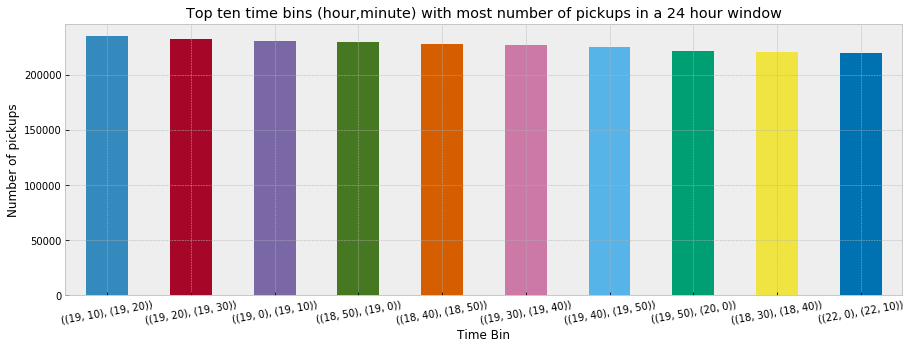

In [86]:
plt.figure(figsize=(15,5))
xticks = [(daily_bins[b],daily_bins[b+1]) for b in df_jul_aug_2015.bin.value_counts().head(10).index.tolist()]
ax = df_jul_aug_2015.bin.value_counts().head(10).plot(kind='bar', rot=10)
_ = plt.title('Top ten time bins (hour,minute) with most number of pickups in a 24 hour window')
_ = plt.xlabel('Time Bin')
_ = plt.ylabel('Number of pickups')
_ = ax.set_xticklabels(xticks)
_ = plt.plot()

Similarly, what are the time bins during which there are least number of pickups? As expected, not a lot of pickups happen in early morning between 4 to 5 am.

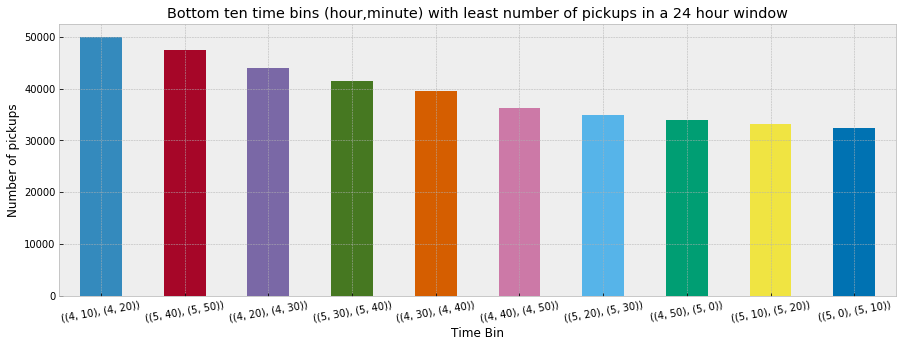

In [87]:
xticks = [(daily_bins[b],daily_bins[b+1]) for b in df_jul_aug_2015.bin.value_counts().tail(10).index.tolist()]
ax = df_jul_aug_2015.bin.value_counts().tail(10).plot(kind='bar', rot=10)
_ = plt.title('Bottom ten time bins (hour,minute) with least number of pickups in a 24 hour window')
_ = plt.xlabel('Time Bin')
_ = plt.ylabel('Number of pickups')
_ = ax.set_xticklabels(xticks)
_ = plt.plot()

## Number of pickups for all Time bins

Let's see the complete picture of pickup distribution across all 144 time bins of a day.

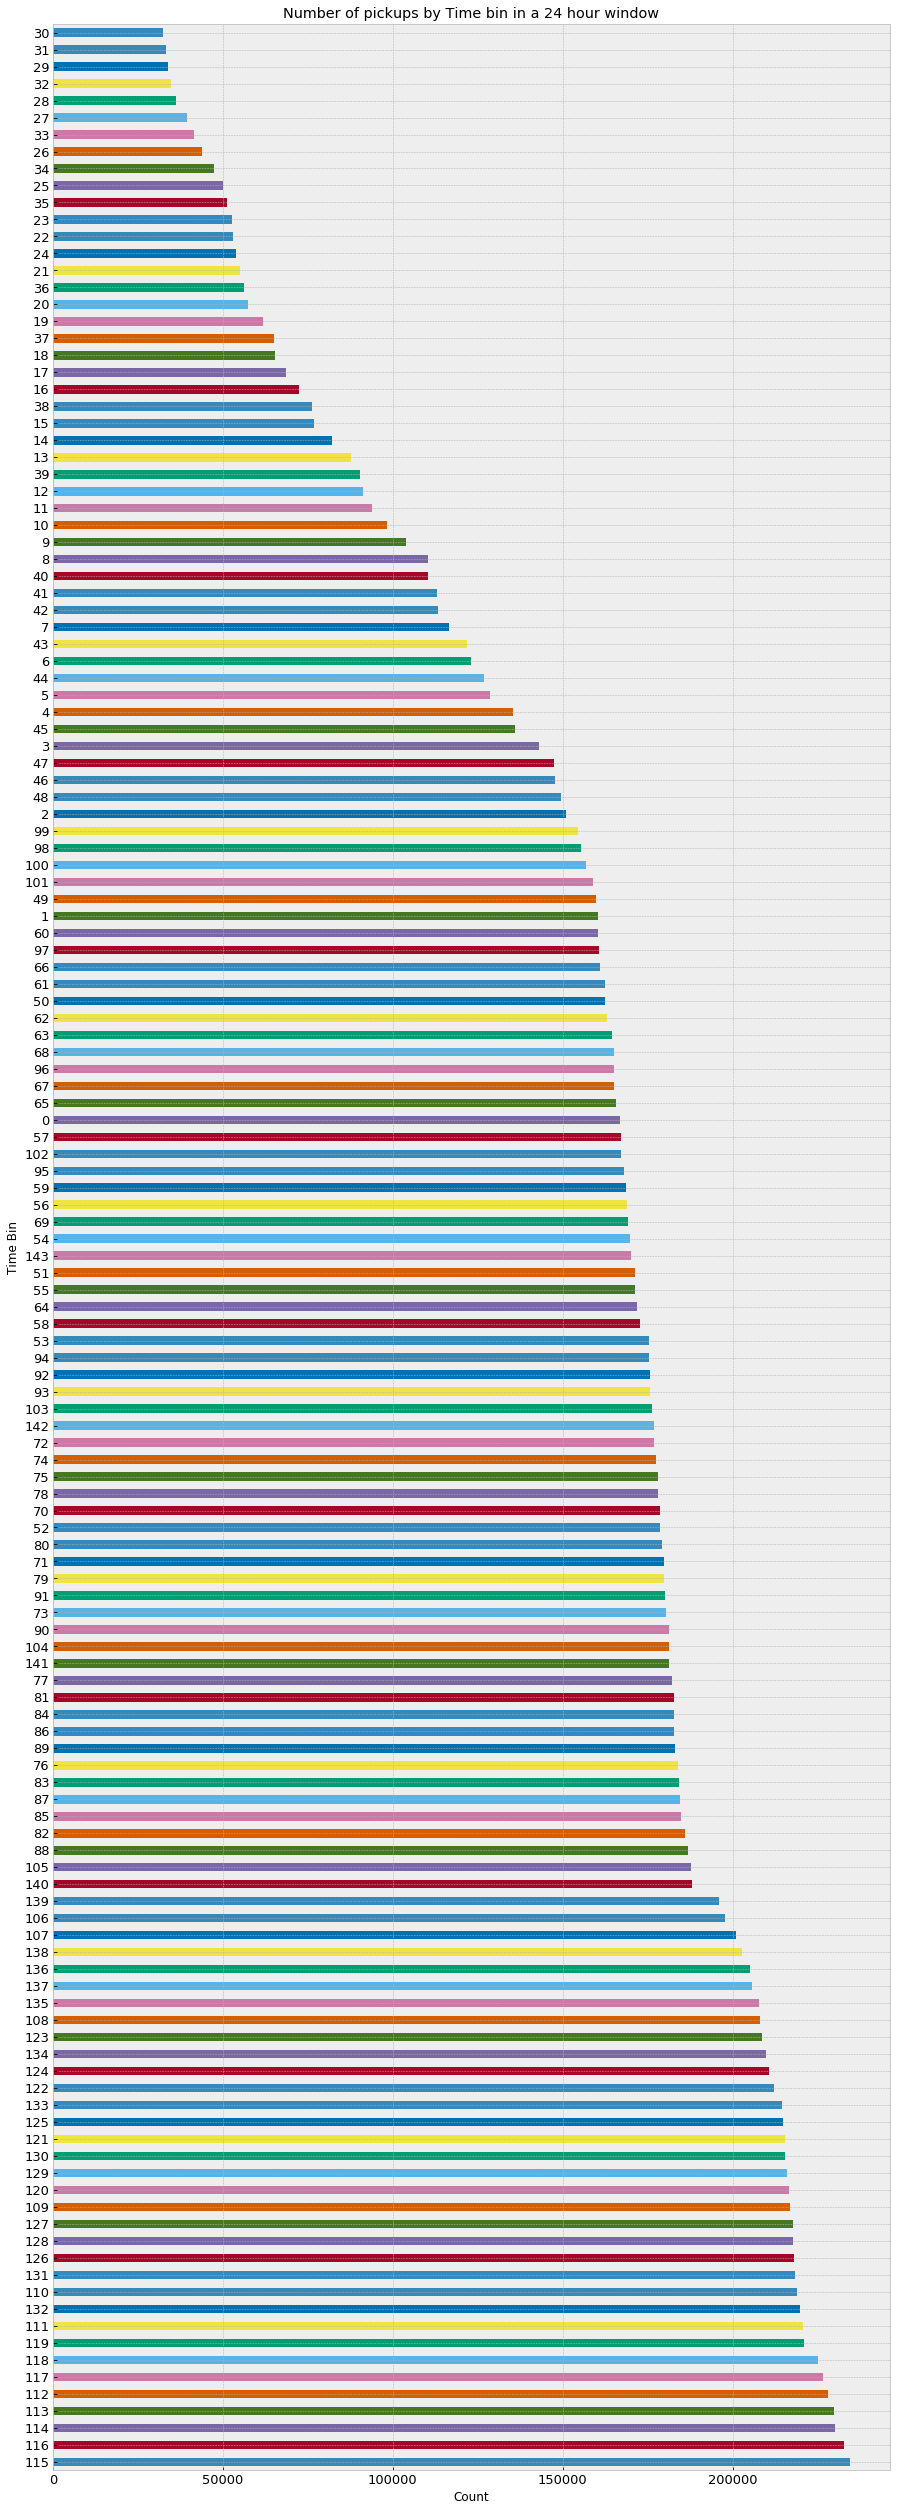

In [97]:
plt.figure(figsize=(15,45))
ax = df_jul_aug_2015.bin.value_counts().plot.barh(rot =0)
_ = plt.xticks(fontsize = 13)
_ = plt.yticks(fontsize = 13)
_ = plt.xlabel('Count')
_ = plt.ylabel('Time Bin')
_ = plt.title('Number of pickups by Time bin in a 24 hour window')

## How does the Taxi demand change with time?  

We have sampled the data into 10 minute bins. Using this, we can plot a graph of the number of pickups in each time bin between **1st July, 2015** to **31st August, 2015**. Can we observe any pattern in it? y axis shows the number of pickups, while x axis the time.

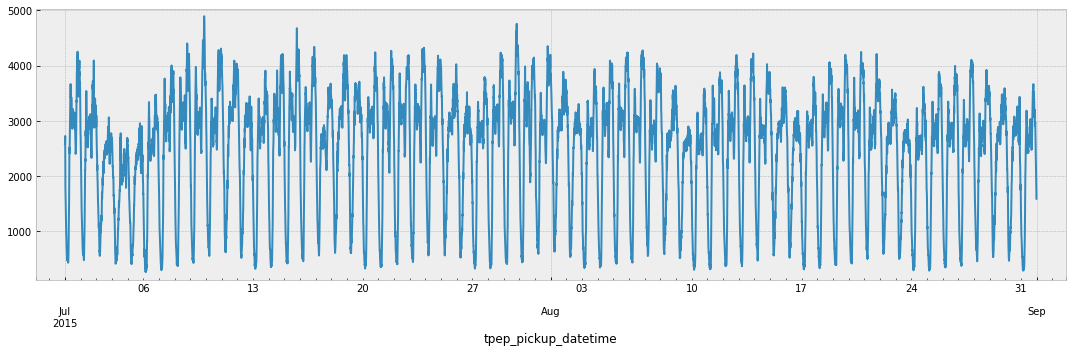

In [98]:
df_jul_aug_2015.reset_index(inplace=True)

df_jul_aug_2015.tpep_pickup_datetime = pd.to_datetime(df_jul_aug_2015.tpep_pickup_datetime)
_ = df_jul_aug_2015.set_index('tpep_pickup_datetime').resample('10T').count()['pickup_latitude'].plot()

plt.margins(0.03)
plt.tight_layout()

There definitely seems to be some wave like pattern in the number of pickups throughout the day. Let's zoom into this graph and observe the pattern for the two weeks between August 1 and August 14.

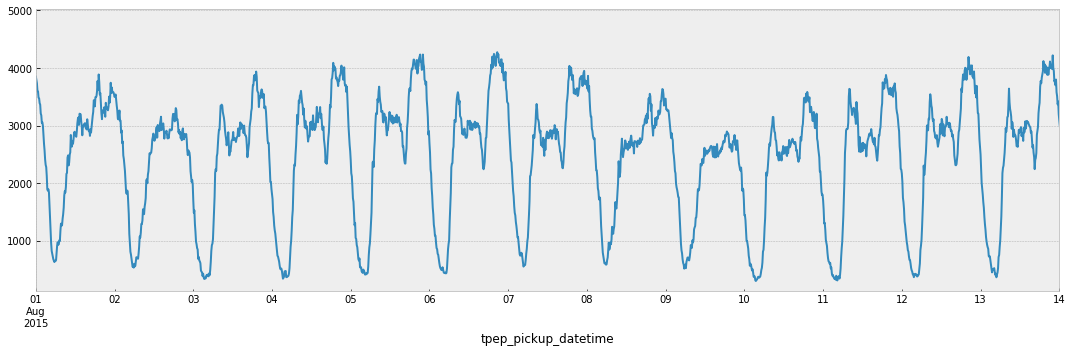

In [99]:
_ = df_jul_aug_2015.set_index('tpep_pickup_datetime').resample('10T').count()['pickup_latitude'].plot()
#_ = df_jul_aug_2015.resample('10T').count()['pickup_longitude'].plot()
plt.xlim(['2015-08-01', '2015-08-14'])
plt.margins(0.03)
plt.tight_layout()

Very interesting. We can be sure now that the number of pickups most certainly follows a day to day pattern. They start off slowly at the beginning of the day, reach a peak during the evening, and then again slow down. Not just that, but which day of the week it is also has an effect on the demand for taxis, although it is not very apparent in the example above. On weekends, the demand is different as compared to other days, for instance.

We'll try to leverage this knowledge in our prediction models. Note that we have not yet divided the NYC area into various regions. We will again observe such a timeseries pattern for each region.

## New Feature: pickup_cluster

Recall that according to our hypothesis, the demand for a taxi is dependent on three things:

        1. Time of the day
        2. Region where the taxi is
        3. Day of the week

We saw in the last section how time and day can determine the number of pickups. Now, we'll try to analyze how this demand varies with region. NYC is a large area. It is possible that different regions have different demand for taxis during the same time period. So, let's divide the New York City into various regions using K-Means clustering based on latitude-longitude coordinates.

But what is the optimal value of `K` that we should use?  The idea is that the inter-cluster distance shouldn't be too small or too large and also that there should be reasonable number of clusters within a vicinity while the rest are outside it. We can assume that a driver wouldn't mind traveling a distance of ~2 miles to get a pickup.

Based on these assumptions, let's try to find the optimal K.

In [8]:
pickup_coordinates = df_jul_aug_2015[['pickup_latitude', 'pickup_longitude']].values
pickup_coordinates.shape

(22225233, 2)

In [101]:
def find_min_dist(cluster_centers):
    n_clusters = len(cluster_centers)
    
    near_points = 0
    far_points = 0
    
    less = []
    more = []
    
    min_dist = 1000
    
    for i in range(n_clusters):
        
        near_points = 0
        far_points = 0
        
        for j in range(n_clusters):
            
            if j != i:
                
                cluster_i_center = (cluster_centers[i][0], cluster_centers[i][1])
                cluster_j_center = (cluster_centers[j][0], cluster_centers[j][1])
                
                dist_i_j = distance.distance(cluster_i_center, cluster_j_center).miles
                
                min_dist = min(min_dist, dist_i_j)
                
                if dist_i_j <= 2:
                    near_points += 1
                else:
                    far_points += 1
        
        less.append(near_points)
        more.append(far_points)
    
    neighbors.append(less)
    
    print ("On choosing a cluster size of ",n_clusters,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less)/len(less)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more)/len(more)),"\nMin inter-cluster distance = ",min_dist,"\n---")
    
        

In [102]:
def find_clusters(cluster_size):
    kmeans = MiniBatchKMeans(n_clusters=cluster_size, batch_size=20000, random_state=13).fit(pickup_coordinates)
    cluster_centers = kmeans.cluster_centers_
    return cluster_centers

We want clusters within a vicinity to be as close as possible to the total number of clusters.

In [103]:
neighbors = []

for cluster_size in range(36,54,4):
    cluster_centers = find_clusters(cluster_size)
    find_min_dist(cluster_centers)

On choosing a cluster size of  36 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 27.0 
Min inter-cluster distance =  0.472187561511111 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 10.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 30.0 
Min inter-cluster distance =  0.40662596298211773 
---
On choosing a cluster size of  44 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 10.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 34.0 
Min inter-cluster distance =  0.43995402401201156 
---
On choosing a cluster size of  48 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 11.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 37.0 
Min inter-cluster dist

Looking at the numbers above, the value of K=36 seems suitable. The next step is to assign each record in our dataframe to a cluster based on the latitude-longitude value of the location where the pickup happened.

In [9]:
kmeans = MiniBatchKMeans(n_clusters=36, batch_size=10000,random_state=13).fit(pickup_coordinates)
df_jul_aug_2015['pickup_cluster'] = kmeans.predict(df_jul_aug_2015[['pickup_latitude', 'pickup_longitude']])

In [10]:
df_jul_aug_2015.head()

,tpep_pickup_datetime,index,pickup_latitude,pickup_longitude,bin,pickup_cluster
0,2015-07-01 00:00:00,0,40.751125,-73.994156,0,11
1,2015-07-01 00:00:00,1,40.768486,-73.984657,0,23
2,2015-07-01 00:00:00,2,40.762287,-73.978889,0,12
3,2015-07-01 00:00:00,3,40.742760,-73.992790,0,13
4,2015-07-01 00:00:00,4,40.769810,-73.912430,0,28


### Cluster Centers

Let's see the cluster centers on the map of New York City.

In [14]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], zoom_start= 11)#, tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

In [418]:
f = open('cluster_centers.pkl', 'wb')
pickle.dump(kmeans.cluster_centers_, f)
f.close()

## Visualizing the clusters

We saw the Map of NYC at the beginning of this notebook.
Let's see how we divided it into various clusters based on the Latitude-Longitude values of taxi pickups. Each cluster is shown with a distinct color. Although there are repeated colors due to plotting limitations of the library, they are  separate clusters.

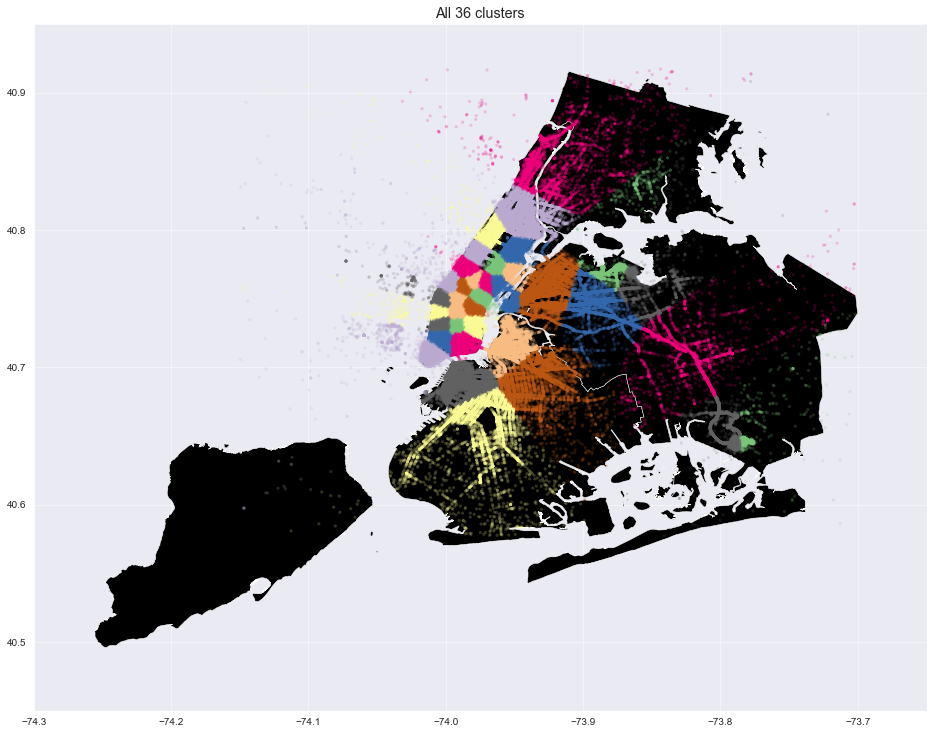

In [23]:
rcParams['figure.figsize'] = (16,16)
sbn.set_style('darkgrid')

ax = taxi_zones_shapes.plot(color='k')

ax.scatter(df_jul_aug_2015.pickup_longitude.values[:5000000],\
           df_jul_aug_2015.pickup_latitude.values[:5000000], \
           s=10, lw=0, c=df_jul_aug_2015.pickup_cluster.values[:5000000], \
           cmap='Accent', alpha=0.2)

plt.xlim([-74.3, -73.650])
plt.ylim([40.450, 40.95])

plt.title('All 36 clusters')
plt.show()

Notice that, Manhattan being a very crowded place, the clusters are small in size but very close to each other.

In [5]:
clusters = df_jul_aug_2015.pickup_cluster.unique()
bins = df_jul_aug_2015.bin.unique()

### Number of pickups by cluster number

Let's see how the pickups are distributed across clusters. Cluster 4 has the maximum number of pickups, while cluster 24 the least.

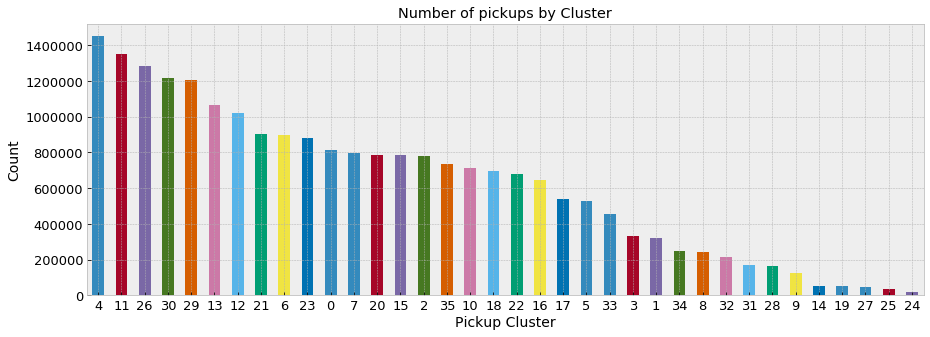

In [17]:
_ = df_jul_aug_2015.pickup_cluster.value_counts().plot(kind='bar', rot=0)
_ = plt.xlabel('Pickup Cluster',fontsize=14)
_ = plt.ylabel('Count',fontsize=14)
_ = plt.xticks(fontsize=13)
_ = plt.yticks(fontsize=13)
_ = plt.title('Number of pickups by Cluster')
plt.show()

### Pickups in a cluster

Earlier we saw top 10 bins with highest number of pickups across all clusters. Similarly, we can find the bins with highest pickups only for a given cluster. 

In [116]:
df_cluster_bin_grouped = df_jul_aug_2015.reset_index().\
                         groupby(['pickup_cluster', 'bin'])['tpep_pickup_datetime'].count()

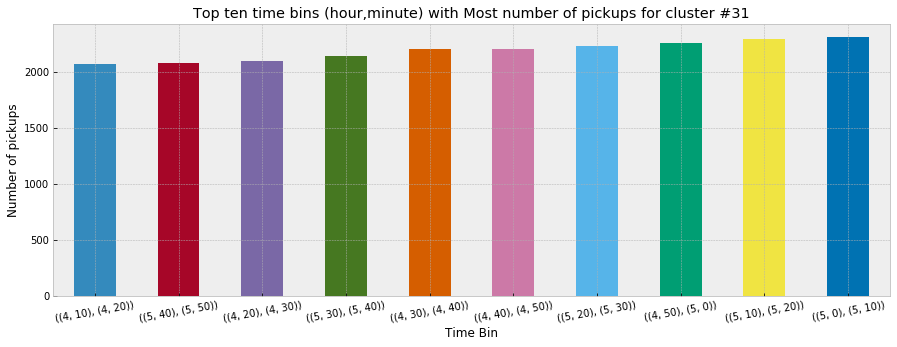

In [117]:
rcParams['figure.figsize'] = (15,5)
cluster_number = 31
#xticks = [(daily_bins[b], daily_bins[b+1]) for b in df_cluster_bin_grouped.loc[(cluster_number,)].sort_values().tail(10).index]
xticks = [(daily_bins[b],daily_bins[b+1]) for b in df_jul_aug_2015.bin.value_counts().tail(10).index.tolist()]
ax = df_cluster_bin_grouped.loc[(cluster_number,)].sort_values().tail(10).plot(kind='bar', rot=10)
_ = plt.title('Top ten time bins (hour,minute) with Most number of pickups for cluster #{}'.format(cluster_number))
_ = plt.xlabel('Time Bin')
_ = plt.ylabel('Number of pickups')
_ = ax.set_xticklabels(xticks)
_ = plt.plot()

# Does Taxi demand change with region?

Following is a plot of the number of pickups for the first two weeks of July for each cluster.

In [123]:
#df_jul_aug_2015.tpep_pickup_datetime = pd.to_datetime(df_jul_aug_2015.tpep_pickup_datetime)
df_jul_aug_2015.set_index('tpep_pickup_datetime', inplace=True)

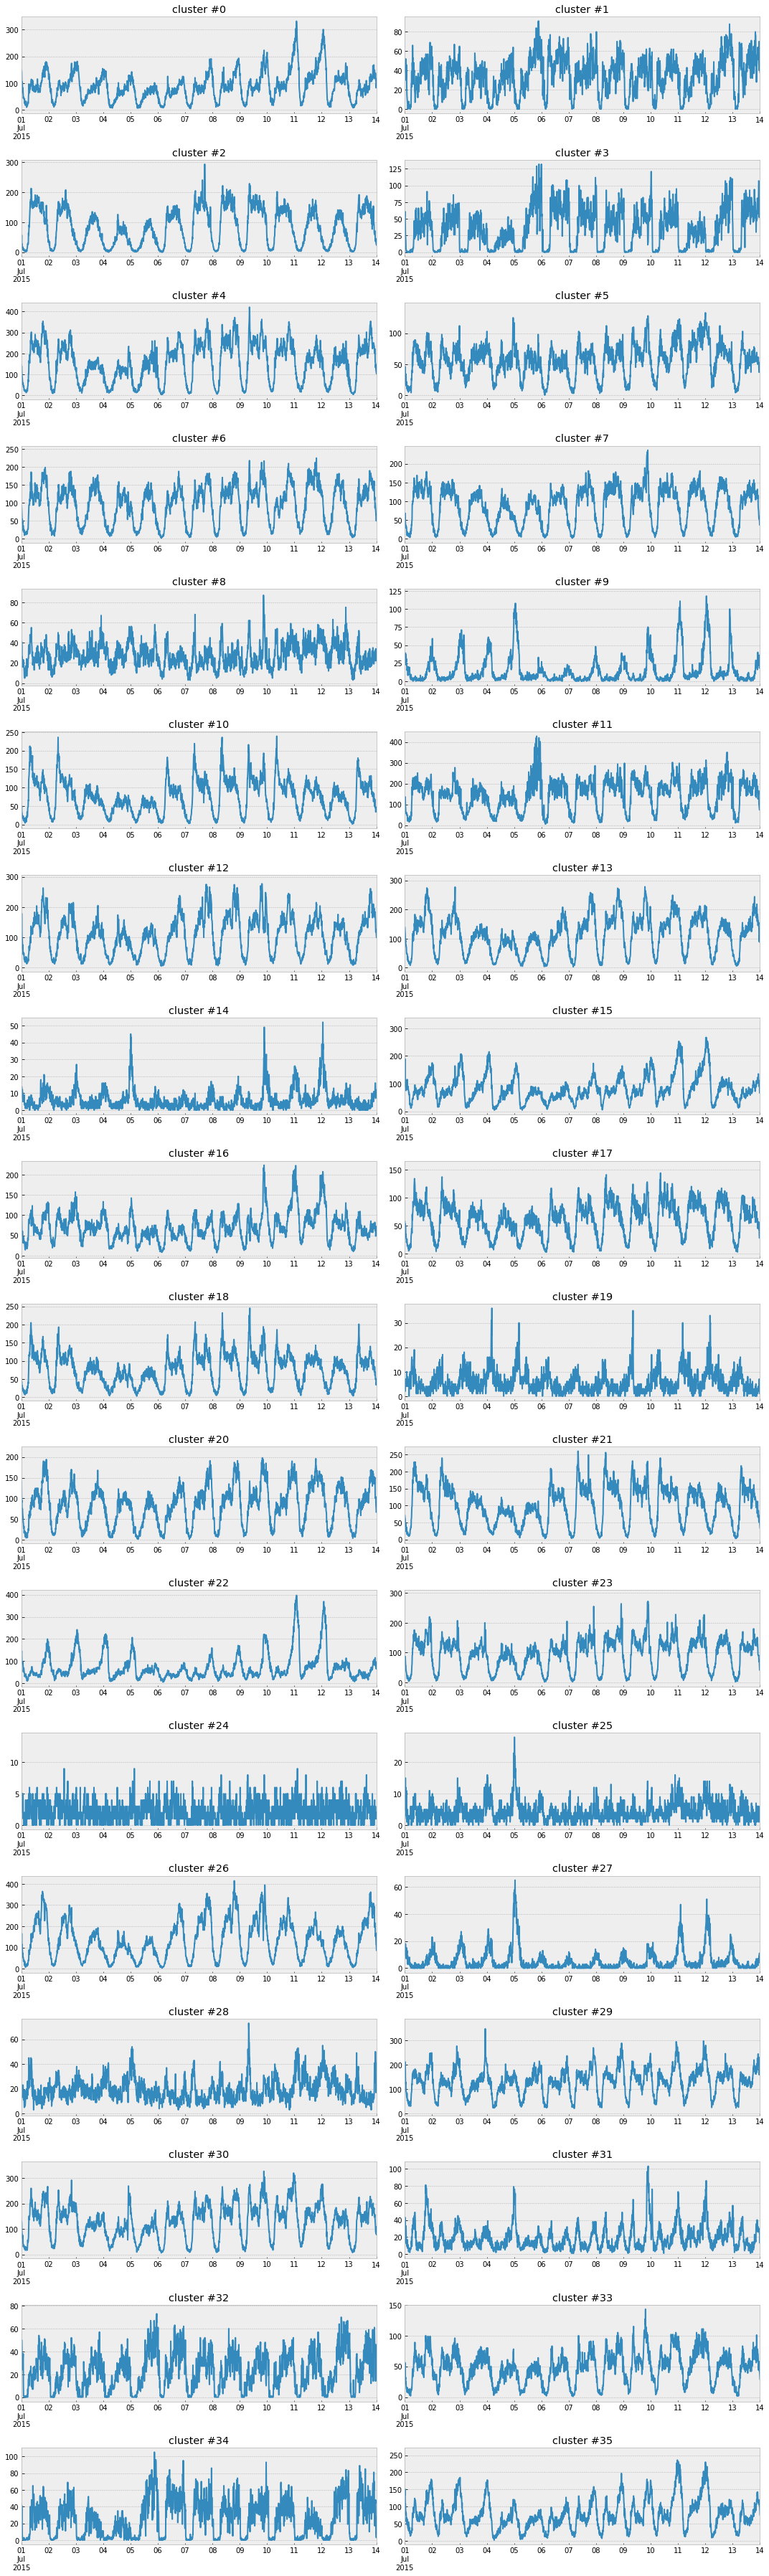

In [124]:
plt.figure(figsize=(15,50))
clusters = df_jul_aug_2015.pickup_cluster.unique()
for c in clusters:
    plt.subplot(18,2,c+1)
    filter_by_cluster = df_jul_aug_2015.pickup_cluster == c
    # df_jul_aug_2015[filter_by_cluster].set_index('tpep_pickup_datetime').resample('10T').count()['bin'].plot()
    df_jul_aug_2015[filter_by_cluster].resample('10T').count()['bin'].plot()
    plt.title('cluster #{}'.format(c))
    plt.xlim(['2015-07-01','2015-07-14'])
    plt.xlabel('')
plt.tight_layout()

As you can observe above, for any cluster, the pattern in daily number of pickups tends to repeat every day. However, if you compare two different clusters, there's often a significant variation in pickup patterns. For instance, compare clusters 25 and 7. They clearly have a large difference in taxi demand during the 24 hours of a day.

See below the strikingly different pickup patterns between clusters 25 and 7. 

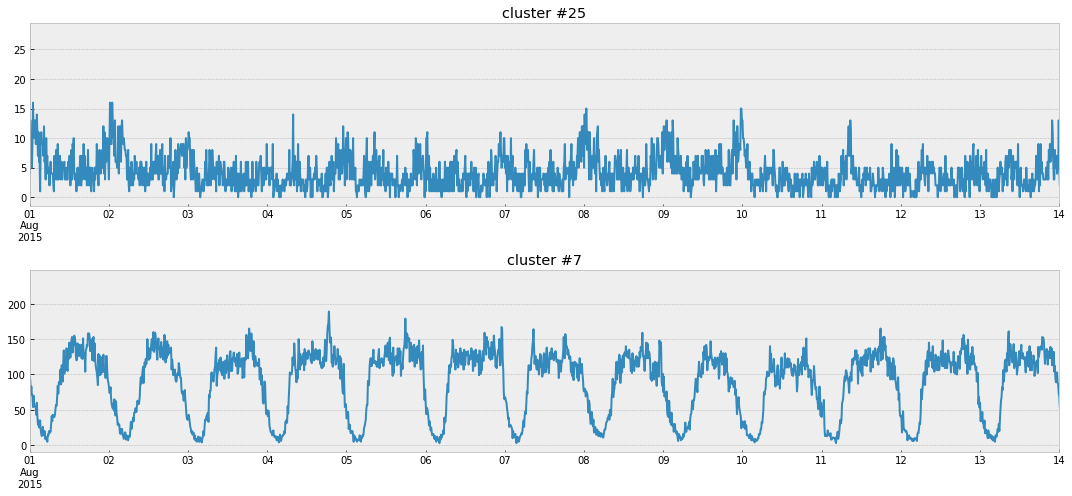

In [128]:
plt.figure(figsize=(15,7))
for i, c in enumerate([25,7]):
    plt.subplot(2,1,i+1)
    filter_by_cluster = df_jul_aug_2015.pickup_cluster == c
    # df_jul_aug_2015[filter_by_cluster].set_index('tpep_pickup_datetime').resample('10T').count()['pickup_latitude'].plot()
    df_jul_aug_2015[filter_by_cluster].resample('10T').count()['pickup_latitude'].plot()
    plt.title('cluster #{}'.format(c))
    plt.xlim(['2015-08-01', '2015-08-14'])
    plt.xlabel('')
plt.tight_layout()

Fascinating, isn't it? Number of pickups does indeed depend on the location. Thus, our hypothesis that taxi demand is affected by the region in which the taxi is present is also sound.

# Foundation of our prediction models

So basically our baseline assumption is -

<img src="https://latex.codecogs.com/gif.latex?\LARGE&space;N&space;=&space;f(cluster_k,bin_t,day_d)" title="\LARGE N = f(cluster_k,bin_t,day_d)" />


i.e. the number of pickups `N` is a function of - 

* the cluster (region) *k* in which the taxi is present
* the time bin *t* of the day
* the day of the week *d*  

For function $f$ we'll try the following :

        1. Simple Moving Averages
        2. Weighted Moving Averages
        3. Exponentially weighted Moving Averages
        4. Using all One-Hot-Encoded features
                i.  Linear Regression w/o regularization
                ii. Ridge Regression
                iii. Lasso Regression
        5. Using indicator variables and one-hot-encoded featue for only weekday
                i. Linear Regression
                ii. Ridge  Regression
                iii. Lasso Regression
                iv. Random Forests Regressor
                v. Gradient Boosted Regressor
                vi. K-Neighbors Regressor
        6. Using just indicator variables for pickup_cluster and time bin
                i. Linear Regression
                ii. Ridge Regression
                iii. Lasso Regression
                iv. Random Forests Regressor
                v. Gradient Boosted Regressor
                vi. K-Neighbors Regressor

In [129]:
df_jul_aug_2015.sort_index(inplace=True)
df_jul_aug_2015.reset_index(inplace=True)

**Finding the day of week from the timestamp**

Here's another benefit of using Pandas - It has an inbuilt method that allows you to extract the `day of week` from a timestamp object with the `.dayofweek` attribute.

> df_jul_aug_2015.tpep_pickup_datetime.dt.dayofweek

The days of the week are numbered from 0 to 6 with mapping:

        Mon: 0 
        Tue: 1
        Wed: 2
        Thu: 3
        Fri: 4
        Sat: 5
        Sun: 6


Unique days in the dataframe

In [130]:
df_jul_aug_2015.tpep_pickup_datetime.dt.dayofweek.unique()

array([2, 3, 4, 5, 6, 0, 1])

Select only the columns which are needed

In [27]:
#df_jul_aug_2015.tpep_pickup_datetime = pd.to_datetime(df_jul_aug_2015.tpep_pickup_datetime)
df_jul_aug_2015 = df_jul_aug_2015[['tpep_pickup_datetime', 'bin', 'pickup_cluster']]

In [28]:
df_jul_aug_2015.head()

,tpep_pickup_datetime,bin,pickup_cluster
0,2015-07-01 00:00:00,0,11
1,2015-07-01 00:00:00,0,23
2,2015-07-01 00:00:00,0,12
3,2015-07-01 00:00:00,0,13
4,2015-07-01 00:00:00,0,28


## Calculating the number of pickups in previous weeks

This is an important calculation that we'll use extensively ahead. So, it's worth spending some time to understand it well. Suppose you want to find the number of pickups on all previous `Saturdays` between 6:20 to 6:30 pm (time-bin `110`), in cluster number `23`, you first create a boolean series like this -

In [35]:
daily_bins.index((18, 20))

110

In [31]:
day = 5 # Mon:0 | Tue:1 | Wed:2 | Thu:3 | Fri:4 | Sat:5 | Sun:6
bn = 110
cluster_no = 23

trips_on_day = (df_jul_aug_2015.tpep_pickup_datetime.dt.dayofweek == day) & \
                (df_jul_aug_2015.bin == bn) &\
                (df_jul_aug_2015.pickup_cluster == cluster_no)

What were the dates on `Saturdays` between July 1 to August 31 of 2015? find it with:

In [32]:
df_jul_aug_2015[trips_on_day].sort_values(by='tpep_pickup_datetime').tpep_pickup_datetime.dt.day.unique()

array([ 4, 11, 18, 25,  1,  8, 15, 22, 29])

Now, just filter the dataframe on the boolean condition you defined above.

However, since you've applied a `groupby` operation, the column names have lost their meaning and all of them simply indicate the `count` of rows satisfying the groupby condition, in other words, they are just number of pickups on each Saturday in cluster 23 between 6:20 to 6:30 pm.

See the dataframe below. The index corresponds to the actual dates. Can you notice any pattern? The number of pickups are close enough that we can try to predict the value on a date, in a time-bin in a cluster using the previous values.

In [33]:
#df_jul_aug_2015[trips_on_friday].sort_values(by='tpep_pickup_datetime').groupby(df_jul_aug_2015.tpep_pickup_datetime.dt.day).count()
df_jul_aug_2015[trips_on_day].groupby(df_jul_aug_2015.tpep_pickup_datetime.dt.day).count()

,tpep_pickup_datetime,bin,pickup_cluster
tpep_pickup_datetime,,,
1,188,188,188
4,107,107,107
8,129,129,129
11,159,159,159
15,129,129,129
18,154,154,154
22,140,140,140
25,155,155,155
29,148,148,148


In the following dataframe, notice how for the same time-bin and day but for a different cluster, the number of pickups change drastically. However, they still show a pattern with previous week values. All of them are in a single digit.

In [34]:
day = 5 # Mon:0 | Tue:1 | Wed:2 | Thu:3 | Fri:4 | Sat:5 | Sun:6
bn = 110
cluster_no = 14

trips_on_day = (df_jul_aug_2015.tpep_pickup_datetime.dt.dayofweek == day) & \
                (df_jul_aug_2015.bin == bn) & \
                    (df_jul_aug_2015.pickup_cluster == cluster_no)

df_jul_aug_2015[trips_on_day].groupby(df_jul_aug_2015.tpep_pickup_datetime.dt.day).count()

,tpep_pickup_datetime,bin,pickup_cluster
tpep_pickup_datetime,,,
1,8,8,8
4,7,7,7
8,8,8,8
11,7,7,7
15,13,13,13
18,6,6,6
22,6,6,6
25,5,5,5
29,6,6,6


However, there is a caveat in the above numbers. In the index, because it's sorted, the dates of July and August have been mixed. This won't matter for simple moving averages, but for weighted and exponential moving averages, it's necessary that the time windows are in the correct order.

To get the count of pickups in the correct order i.e. dates in July first then August, we can manipulate the list as given below.  

In [35]:
df_jul_aug_2015[trips_on_day].groupby(df_jul_aug_2015.tpep_pickup_datetime.dt.day)['bin'].count().tolist()[::2] + \
df_jul_aug_2015[trips_on_day].groupby(df_jul_aug_2015.tpep_pickup_datetime.dt.day)['bin'].count().tolist()[1::2]

[8, 8, 13, 6, 6, 7, 7, 6, 5]

## Training and Test data

Let's divide the original dataset into train and test sets. We will consider the data between 1st July to 25th of August (total 55 days) as training data. While the rest will be Test data.

* df_last_week: Test Data
* df_training_data: Training Data

In [251]:
#df_jul_aug_2015.reset_index(inplace=True)

In [36]:
# Extrct last week of August as Test data
data_of_last_week = (df_jul_aug_2015.tpep_pickup_datetime > '2015-08-25 00:00:00') &\
                    (df_jul_aug_2015.tpep_pickup_datetime < '2015-08-31 23:59:59')

df_last_week = df_jul_aug_2015[data_of_last_week]

# Extrct Train data
data_excluding_last_week = (df_jul_aug_2015.tpep_pickup_datetime > '2015-07-01 00:00:00') &\
                            (df_jul_aug_2015.tpep_pickup_datetime < '2015-08-25 23:59:00')

df_training_data = df_jul_aug_2015[data_excluding_last_week]

## Function to calculate Mean Absolute Percentage Error (MAPE)

MAPE is defined as:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/4cf2158513b0345211300fe585cc88a05488b451)

where $A_t$ is the actual value and $F_t$ is the forecast value. This function takes in two arrays/lists and returns the MAPE value.

In [37]:
def MAPE(actual, predicted):
    
    if type(actual) is list:
        actual= np.array(actual)
    if type(predicted) is list:
        predicted = np.array(predicted)
    
    return (np.sum(np.abs((actual - predicted)/actual)) / len(actual)) * 100

## Model 1 : Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

The formula is given by - 

$$\begin{align}N_{t} = ( N_{t-1} + N_{t-2} + N_{t-3} .... N_{t-n} )/n \end{align}$$

where, $N$ represents the number of pickups in the previous week for the same time-bin, pickup cluster and day. Since our training data is about 55 days, we can use the values of past 7 to 8 weeks to calculate the moving averages. i.e. our window size will be 7 or 8 depending on the day.

Here are the steps to calculate the simple moving averages :

            1. Sample n = 100k random test data points
            2. For each of the points in the random sample for the given cluster, 
                i. obtain the time-bin to which that pickup belongs
                ii. obtain the day of week for that pickup
                iii. Based on the Previous 7 to 8 weeks data, calculate the simple moving average
            3. Calculate the Mean Absolute Percentage Error 

In [94]:
%%notify
%%time

count = 0
cluster_no = 13# 6, 11, 12

# variable for "absolute error"
ae = 0

# Filter on cluster number first
DF = df_jul_aug_2015[df_jul_aug_2015.pickup_cluster == cluster_no]

# randomly sample 100k datetimes from test dataset
n = 100000
tymes = df_last_week.sample(n).tpep_pickup_datetime

# Arrays to store actual and predicted values of the number of pickups
# in the time-bin and on the day of the test query point in the given cluster
actual = [] 
predicted = [] 

print('************* Testing Simple Moving averages **************', end = '\n\n')
print('--------------OUTPUT MEANING----------------', end='\n\n')
print('Cluster Number | Timestamp ==> Predicted Value[#past weeks considered] --> Actual Value', end = '\n\n')
print('*'*40)    
    
for tyme in tymes:

    bin_of_tyme = bin_time(tyme)

    # find whether it's a sun, mon, tue, wed, thu, fri or sat
    day = tyme.dayofweek

    # boolean series to find - on this day, in the current time-bin, in the given cluster, 
    # how many trips were made in the previous weeks
    trips_on_day = (DF.tpep_pickup_datetime.dt.dayofweek == day) &\
                   (DF.bin == bin_of_tyme)

    # create a list of number of pickups grouped by previous several dates having the particular `day`
    trips_count_of_last_few_days = DF[trips_on_day].groupby(DF.tpep_pickup_datetime.dt.day)['bin'].count().tolist()

    # Except the last element of the above list, which is the count of trips on the last `day` of the month, 
    # (`day` here means - Monday, Tuesday, Wednesday etc. and NOT a date like 30,31 etc.) calculate the avg.
    # In other words, since the last week of August 2015 is our test data, the last value in the above list is 
    # the actual target value we're trying to predict. Therefore, for calculating the average, 
    # we sum upto the last-but-one element 

    last_few_days_avg = sum(trips_count_of_last_few_days[:-1]) / ( len(trips_count_of_last_few_days) - 1 )

    # Store the actual value
    y_actual = trips_count_of_last_few_days[-1]

    predicted.append(last_few_days_avg)
    actual.append(y_actual)

    count += 1

    if count < 50:

        print('cluster #{} | {} ==> {}[{}] --> {}'.format(cluster_no,tyme,last_few_days_avg,( len(trips_count_of_last_few_days) - 1 ),y_actual), end='\n')

mape = MAPE(actual, predicted)
r2 = r2_score(actual, predicted)

print('\n********************************************\n')
print('MAPE using Simple Moving averages: {}%'.format(mape))
print('r2 score using Simple Moving averages: {}%'.format(r2))

************* Testing Simple Moving averages **************

--------------OUTPUT MEANING----------------

Cluster Number | Timestamp ==> Predicted Value[#past weeks considered] --> Actual Value

****************************************
cluster #13 | 2015-08-31 08:25:46 ==> 116.5[8] --> 103
cluster #13 | 2015-08-31 00:15:34 ==> 51.125[8] --> 57
cluster #13 | 2015-08-27 14:00:59 ==> 167.75[8] --> 189
cluster #13 | 2015-08-31 00:24:29 ==> 43.75[8] --> 38
cluster #13 | 2015-08-26 19:16:00 ==> 248.375[8] --> 287
cluster #13 | 2015-08-25 07:24:20 ==> 105.42857142857143[7] --> 118
cluster #13 | 2015-08-26 17:32:03 ==> 172.0[8] --> 171
cluster #13 | 2015-08-30 17:15:36 ==> 128.0[8] --> 148
cluster #13 | 2015-08-25 22:33:40 ==> 188.28571428571428[7] --> 192
cluster #13 | 2015-08-29 23:04:52 ==> 163.5[8] --> 172
cluster #13 | 2015-08-30 18:10:11 ==> 140.875[8] --> 148
cluster #13 | 2015-08-31 14:01:37 ==> 136.125[8] --> 147
cluster #13 | 2015-08-26 19:05:37 ==> 241.25[8] --> 254
cluster #13 | 2

<IPython.core.display.Javascript object>

**Function to help plot a bar chart**

In [95]:
def make_df(times, actual, predicted):
    how_many = len(actual)
    labels = ['actual']*how_many + ['predicted']* how_many
    return pd.DataFrame({'Number of Pickups':actual+predicted, 'set':labels, 'Time of Pickup':times+times})

### Visual comparison of predicted vs actual number of pickups | Simple Moving Averages

Let's plot a bar graph for a few sample test points, to see the predicted vs the actual number of pickups. Note that the X axis shows the timestamp of the test point. But what it actually indicates is the 10 minute time bin to which it belongs.

You can see that the simple moving averages model has actually performed quite well with MAPE of ~10%. There isn't a lot of variation between the predicted and the actual values.

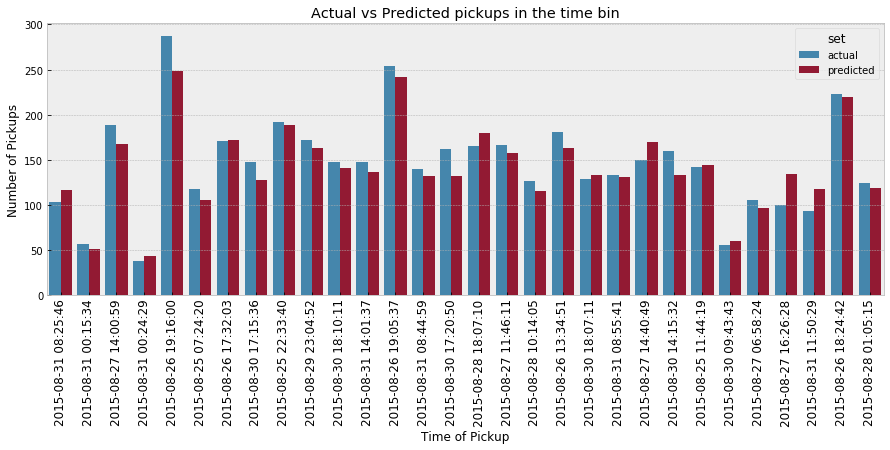

In [96]:
times = tymes.reset_index()['tpep_pickup_datetime'].astype('str').values.tolist()
n = 30
plt.figure(figsize=(15,5))
sbn.barplot(x='Time of Pickup', y='Number of Pickups',hue='set', data=make_df(times[:n], actual[:n], predicted[:n]))
plt.xticks(rotation=90, fontsize=12)
plt.title('Actual vs Predicted pickups in the time bin')
plt.show()

Let's store the results in a table.

In [41]:
table = PrettyTable()
table.field_names = ['#', 'Model', 'Feature','Test Data Size','MAPE', 'r2 Score']
table.add_row(['1', 'Simple Moving Averages', '-','100K', 10.21, 0.89])
table.add_row(['', '', '','', '', ''])

## Model 2 : Weighted Moving Averages

The Simple Moving Averages Model gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones.<br>

Weighted Moving Averages can be defined as - 

$$\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$$

where `R` indicates the previous values and `N` is the window size. 

Similar to Simple moving averages, the steps we'll follow are:

        1. Sample n=100k random test data points
        2. For each of the points in this set for the given cluster, 
            i. obtain the time-bin to which that pickup belongs
            ii. obtain the day of week for that pickup
            iii. Based on the Previous 7 to 8 weeks data, calculate the  Weighted moving average
          
        3. Calculate the Mean Absolute Percentage Error 

In [131]:
%%notify
%%time

count = 0
cluster_no = 26# 13, 18
ae = 0

actual = []
predicted = []

DF = df_jul_aug_2015[df_jul_aug_2015.pickup_cluster == cluster_no]

# randomly sample 100k datetimes from test dataset
n = 100000
tymes = df_last_week.sample(n).tpep_pickup_datetime

print('************* Testing Weighted Moving averages **************', end = '\n\n')
print('--------------OUTPUT MEANING----------------', end='\n\n')
print('Cluster Number | Timestamp ==> Predicted Value[#past weeks considered] --> Actual Value', end = '\n\n')
print('*'*40)

for tyme in tymes:
    
    bin_of_tyme = bin_time(tyme)
    
    # find whether it's a sat, sun, etc.
    day = tyme.dayofweek
    
    # boolean series to find - on this day, in the current time-bin, in the given cluster, 
    # how many trips were made.
    trips_on_day = (DF.tpep_pickup_datetime.dt.dayofweek == day) &\
                   (DF.bin == bin_of_tyme)
        
    # create a list of number of pickups grouped by previous several dates having the particular `day`
    trips_count_of_last_few_days = DF[trips_on_day].groupby(DF.tpep_pickup_datetime.dt.day)['bin'].count().tolist()
    
    # Except the last element of the above list, which is the count of trips on the last `day` of the month 
    # (`day` here means - Monday, Tuesday, Wednesday etc. and NOT a date like 30,31 etc.)
    # In other words, since the last week of August 2015 is our test data, the last value in the above list is 
    # the actual target value we're trying to predict. Therefore, for calculating the average, 
    # we sum upto the last-but-one element 
    
    # Store the actual value
    y_actual = trips_count_of_last_few_days[-1]
    actual.append(y_actual)
    
    # number of pickups in the correct order
    trips_count_of_last_few_days = trips_count_of_last_few_days[:-1][::2] + \
                                   trips_count_of_last_few_days[:-1][1::2]
    
    N = len(trips_count_of_last_few_days)
    denominator = (N * (N+1)) / 2
    
    # initialize weighted moving average sum
    wma = 0
    for x in trips_count_of_last_few_days:
        wma += N * x
        N -= 1
    
    wma /= denominator
    wma = np.round(wma)
    
    predicted.append(wma)
    
    count += 1
    
    if count < 25:
        print('Cluster #{} | {} ==> {}[{}] --> {}'.format(cluster_no,tyme,wma,(len(trips_count_of_last_few_days)),y_actual), end='\n')
    else:
        print(count, end='\r')
    
mape = MAPE(actual, predicted)
r2 = r2_score(actual, predicted)

print('\n********************************************\n')
print('MAPE using Weighted Moving averages: {}%'.format(mape))

************* Testing Weighted Moving averages **************

--------------OUTPUT MEANING----------------

Cluster Number | Timestamp ==> Predicted Value[#past weeks considered] --> Actual Value

****************************************
Cluster #26 | 2015-08-25 13:35:42 ==> 230.0[7] --> 251
Cluster #26 | 2015-08-30 11:16:22 ==> 113.0[8] --> 118
Cluster #26 | 2015-08-28 02:38:13 ==> 60.0[8] --> 57
Cluster #26 | 2015-08-26 03:58:17 ==> 14.0[8] --> 17
Cluster #26 | 2015-08-29 08:42:14 ==> 56.0[8] --> 52
Cluster #26 | 2015-08-26 12:00:17 ==> 239.0[8] --> 296
Cluster #26 | 2015-08-28 16:07:07 ==> 186.0[8] --> 164
Cluster #26 | 2015-08-27 08:56:20 ==> 171.0[8] --> 205
Cluster #26 | 2015-08-28 20:28:58 ==> 195.0[8] --> 221
Cluster #26 | 2015-08-27 06:59:09 ==> 77.0[8] --> 72
Cluster #26 | 2015-08-26 12:57:03 ==> 227.0[8] --> 263
Cluster #26 | 2015-08-26 21:12:31 ==> 331.0[8] --> 374
Cluster #26 | 2015-08-31 07:31:08 ==> 79.0[8] --> 68
Cluster #26 | 2015-08-30 00:52:02 ==> 95.0[8] --> 100
Cl

<IPython.core.display.Javascript object>

### Visual comparison of Actual vs Predicted pickups |  Weighted Moving averages

This model too, performs quite satisfactorily with MAPE of ~ 11%. There's little difference between predicted and actual values in most cases.

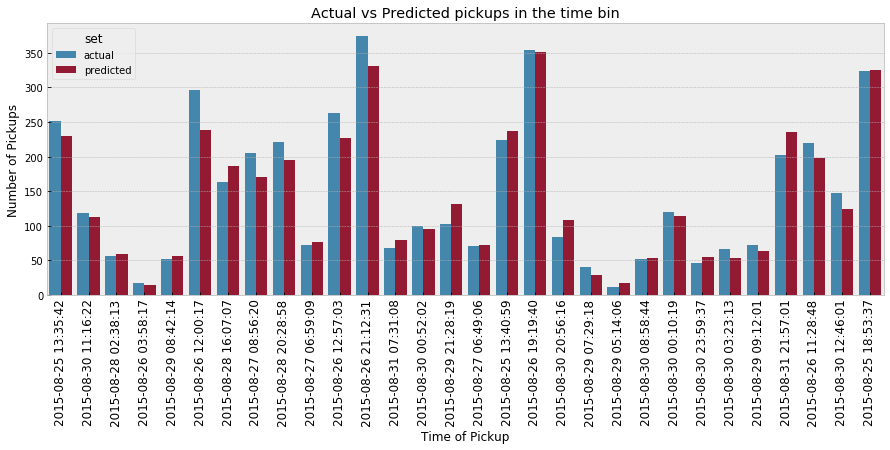

In [132]:
times = tymes.reset_index()['tpep_pickup_datetime'].astype('str').values.tolist()
n = 30
plt.figure(figsize=(15,5))
sbn.barplot(x='Time of Pickup', y='Number of Pickups',hue='set', data=make_df(times[:n], actual[:n], predicted[:n]))
plt.xticks(rotation=90, fontsize=12)
plt.title('Actual vs Predicted pickups in the time bin')
plt.show()

In [42]:
table.add_row(['2','Weighted Moving Averages','-', '100K',11.09, 0.9102])
table.add_row(['', '', '','', '', ''])

## Model 3: Exponential  Weighted Moving Averages

Through weighted averaged we have tried giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinitely many possibilities in which we can assign weights in a non-increasing order.

We will now try Exponential Moving Averages which is a more logical way towards assigning weights.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter, the actual and predicted previous values get their weights. It's a recursive function defined as -


![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/54ece5e7437b18e4955d3e8894426eb819f9eda6)

where,

* The coefficient α represents the degree of weighting decrease, a constant smoothing factor between 0 and 1. A higher α discounts older observations faster.
* Yt is the value at a time period t.
* St is the value of the EMA at any time period t.


The steps we'll follow are :

            1. Sample n random test data points
            2. For each of the points in the random sample for the given cluster, 
                i. obtain the time-bin to which that pickup belongs
                ii. obtain the day of week for that pickup
                iii. Based on the Previous 7 to 8 weeks data, calculate the Exponential weighted moving average
                     
            3. Calculate the Mean Absolute Percentage Error 

**Recursive function to calculate Exponential Weighted Moving averages**

In [135]:
# last_few_days_pickups sorted by most recent
def ewma(last_few_days_pickups, alpha=0.5):
    
    if len(last_few_days_pickups) == 1:
        return last_few_days_pickups[0]
        
    predicted = alpha * last_few_days_pickups[0] + (1 - alpha) * ewma(last_few_days_pickups[1:])
    
    return predicted

In [282]:
%%notify
%%time

count = 0
cluster_no = 16# 18
ae = 0

actual = []
predicted = []

DF = df_jul_aug_2015[df_jul_aug_2015.pickup_cluster == cluster_no]


# randomly sample 100 datetimes from test dataset
n = 100000
tymes = df_last_week.sample(n).tpep_pickup_datetime

print('************* Testing Weighted Moving averages **************', end = '\n\n')
print('--------------OUTPUT MEANING----------------', end='\n\n')
print('Timestamp ==> Predicted Value[#past weeks considered] --> Actual Value', end = '\n\n')
print('*'*40)

for tyme in tymes:
    
    bin_of_tyme = bin_time(tyme)
    
    # find whether it's a sat, sun, etc.
    day = tyme.dayofweek
    
    # boolean series to find - on this day, in the current time-bin, in the given cluster, 
    # how many trips were made.
    trips_on_day = (DF.tpep_pickup_datetime.dt.dayofweek == day) &\
                   (DF.bin == bin_of_tyme)
    
    # create a list of number of pickups grouped by previous several dates having the particular `day`
    trips_count_of_last_few_days = DF[trips_on_day] \
                                    .groupby(DF.tpep_pickup_datetime.dt.day)['bin'].count().tolist()
    
    # Except the last element of the above list, which is the count of trips on the last `day` of the month 
    # (`day` here means - Monday, Tuesday, Wednesday etc. and NOT a date like 30,31 etc.)
    # In other words, since the last week of August 2015 is our test data, the last value in the above list is 
    # the actual target value we're trying to predict. Therefore, for calculating the average, 
    # we sum upto the last-but-one element 
    
    # Store the actual value
    y_actual = trips_count_of_last_few_days[-1]
    actual.append(y_actual)
    
    # count in the correct order of dates
    trips_count_of_last_few_days = trips_count_of_last_few_days[:-1][::2] + \
                                    trips_count_of_last_few_days[:-1][1::2]
    
    # alpha determines how much importance to give to actual previous value
    ewa = ewma(trips_count_of_last_few_days[::-1], alpha=0.65)
        
    predicted.append(ewa)
    
    count += 1
    
    if count < 50:
    
        print('Cluster #{} | {} ==> {}[{}] --> {}'.format(cluster_no,tyme,ewa,(len(trips_count_of_last_few_days)),y_actual), end='\n')
    
    else:
        print(count, end='\r')
    
mape = MAPE(actual, predicted)
r2 = r2_score(actual, predicted)

print('\n********************************************\n')
print('MAPE using Weighted Moving averages: {}%'.format(mape))
print('r2 score using Weighted Moving averages: {}%'.format(r2))

************* Testing Weighted Moving averages **************

--------------OUTPUT MEANING----------------

Timestamp ==> Predicted Value[#past weeks considered] --> Actual Value

****************************************
Cluster #16 | 2015-08-28 07:32:45 ==> 82.84921875[8] --> 95
Cluster #16 | 2015-08-28 23:16:29 ==> 168.878125[8] --> 169
Cluster #16 | 2015-08-31 09:26:02 ==> 88.0640625[8] --> 107
Cluster #16 | 2015-08-31 22:24:56 ==> 78.07578125[8] --> 63
Cluster #16 | 2015-08-26 23:25:56 ==> 97.60390625[8] --> 104
Cluster #16 | 2015-08-31 07:17:15 ==> 89.23515625[8] --> 90
Cluster #16 | 2015-08-26 20:42:31 ==> 82.93437499999999[8] --> 122
Cluster #16 | 2015-08-25 23:06:21 ==> 101.65937500000001[7] --> 107
Cluster #16 | 2015-08-26 18:45:17 ==> 88.0984375[8] --> 107
Cluster #16 | 2015-08-30 06:56:56 ==> 24.54296875[8] --> 26
Cluster #16 | 2015-08-25 09:18:43 ==> 82.1234375[7] --> 64
Cluster #16 | 2015-08-26 12:18:04 ==> 67.31328125[8] --> 56
Cluster #16 | 2015-08-30 03:28:23 ==> 127.1

<IPython.core.display.Javascript object>

### Visual comparison of actual vs predicted number of pickups | EWMA 

EWMA too has performed satisfactorily with MAPE of ~13.65%

Let's see some samples of predicted vs the actual values using this scheme.

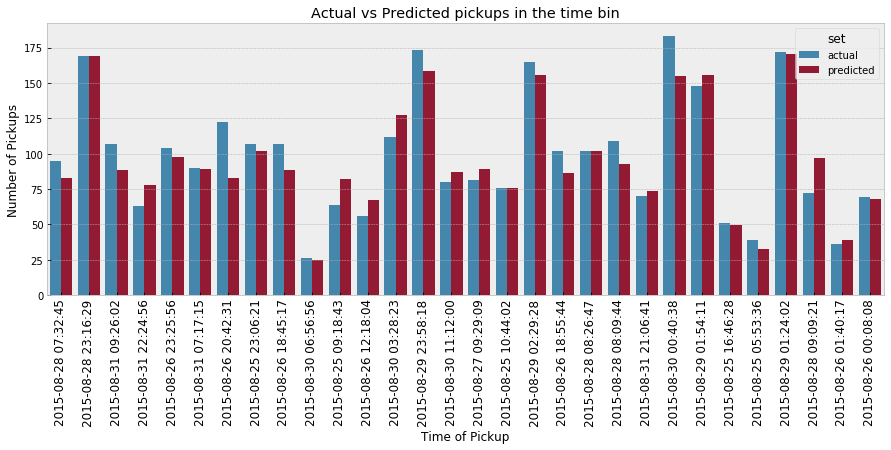

In [283]:
times = tymes.reset_index()['tpep_pickup_datetime'].astype('str').values.tolist()
n = 30
plt.figure(figsize=(15,5))
sbn.barplot(x='Time of Pickup', y='Number of Pickups',hue='set', data=make_df(times[:n], actual[:n], predicted[:n]))
plt.xticks(rotation=90, fontsize=12)
plt.title('Actual vs Predicted pickups in the time bin')
plt.show()

In [43]:
table.add_row(['3','Exponential Weighted Moving Average','-','100K', 13.65 , 0.82])
table.add_row(['', '', '','', '', ''])

# Regression on One Hot Encoded features

It's time for some actual machine learning. We'll try a few regression models based on the same hypothesis that the demand for taxis is a function of time, day and geographical region. But do we have the data for training the ML models? Not yet!

If you look at the our dataframe, although rich in information, it doesn't have data that can be fed into any  machine learning algorithm. `scikit-learn` cannot work with datetime or string objects. Apart from that, what is the target variable in the original dataset that we want to predict using machine learning? There's none!

Hence, we first need to massage our data into such a form that `scikit-learn` can work with it. 

## One Hot Encoding

One hot encoding is a technique in which a categorical feature is transformed into as many columns as there are number of unique values for that feature. Each of these columns can have a binary value 0/1 to indicate whether a particular record has that value of the categorical feature.

In our current dataframe, there's no feature to indicate the day of the week. Let's add it to train as well as test dataframes. And then we'll convert the features into One Hot Encoded format.


In [286]:
df_training_data.head()

,tpep_pickup_datetime,bin,pickup_cluster
7,2015-07-01 00:00:02,0,31
8,2015-07-01 00:00:02,0,34
9,2015-07-01 00:00:02,0,6
10,2015-07-01 00:00:02,0,11
11,2015-07-01 00:00:02,0,30


In [ ]:
df_training_data['day_of_week'] = df_training_data.tpep_pickup_datetime.dt.dayofweek 
df_last_week['day_of_week'] = df_last_week.tpep_pickup_datetime.dt.dayofweek

### Map day number to Name of day 

Since it's a categorical feature, giving meaningful names to its values would make more sense.

In [ ]:
day_to_name = {

              0:'Monday',
              1:'Tuesday',
              2:'Wednesday',
              3:'Thursday',
              4:'Friday',
              5:'Saturday',
              6:'Sunday'
}

df_training_data.day_of_week = df_training_data.day_of_week.map(day_to_name)
df_last_week.day_of_week = df_last_week.day_of_week.map(day_to_name)

### Group Dataframe to uniquely identify by day, bin and cluster

Now that we have the required columns, let's group the dataframe so that we can identify the number of pickups with a combination of date, pickup cluster, and the time-bin. Observe how a set of these three values can uniquely filter out the number of pickups. This gives us lots of data to train our models on.

In [301]:
df_grouped_cluster_bin_date = df_training_data.groupby(['pickup_cluster', 'bin', df_training_data.tpep_pickup_datetime.dt.date])[['tpep_pickup_datetime']].count()
df_TEST_grouped_cluster_bin_date = df_last_week.groupby(['pickup_cluster', 'bin', df_last_week.tpep_pickup_datetime.dt.date])[['tpep_pickup_datetime']].count()

#df_grouped_cluster_bin_date = df_training_data.groupby(['pickup_cluster', 'bin', df_training_data.tpep_pickup_datetime.dt.date]).count()
#df_TEST_grouped_cluster_bin_date = df_last_week.groupby(['pickup_cluster', 'bin', df_last_week.tpep_pickup_datetime.dt.date]).count()

Rename the column and give it a meaningful name

In [304]:
df_grouped_cluster_bin_date.columns = df_TEST_grouped_cluster_bin_date.columns = ['no_of_pickups']

Reset Index

In [305]:
df_grouped_cluster_bin_date.head()

no_of_pickups
pickup_cluster bin tpep_pickup_datetime               
0              0   2015-07-01                      100
                   2015-07-02                      114
                   2015-07-03                      153
                   2015-07-04                      140
                   2015-07-05                       92

In [306]:
df_TEST_grouped_cluster_bin_date.head()

no_of_pickups
pickup_cluster bin tpep_pickup_datetime               
0              0   2015-08-25                       64
                   2015-08-26                      106
                   2015-08-27                      105
                   2015-08-28                      137
                   2015-08-29                      190

Reset index

In [307]:
df_grouped_cluster_bin_date.reset_index(inplace=True)
df_TEST_grouped_cluster_bin_date.reset_index(inplace=True)

Convert pickup time to datetime 

In [308]:
df_grouped_cluster_bin_date.tpep_pickup_datetime = pd.to_datetime(df_grouped_cluster_bin_date.tpep_pickup_datetime)
df_TEST_grouped_cluster_bin_date['tpep_pickup_datetime'] = pd.to_datetime(df_TEST_grouped_cluster_bin_date['tpep_pickup_datetime'])

Add a column "weekday" to the grouped dataframe

In [309]:
df_grouped_cluster_bin_date.head()

,pickup_cluster,bin,tpep_pickup_datetime,no_of_pickups
0,0,0,2015-07-01,100
1,0,0,2015-07-02,114
2,0,0,2015-07-03,153
3,0,0,2015-07-04,140
4,0,0,2015-07-05,92


In [310]:
df_grouped_cluster_bin_date['weekday'] =  df_grouped_cluster_bin_date.tpep_pickup_datetime.dt.dayofweek
df_TEST_grouped_cluster_bin_date['weekday'] =  df_TEST_grouped_cluster_bin_date.tpep_pickup_datetime.dt.dayofweek

Map column number to day

In [311]:
df_grouped_cluster_bin_date.weekday = df_grouped_cluster_bin_date.weekday.map(day_to_name)
df_TEST_grouped_cluster_bin_date.weekday = df_TEST_grouped_cluster_bin_date.weekday.map(day_to_name)

Give appropriate names to columns

In [312]:
df_grouped_cluster_bin_date.columns = ['pickup_cluster', 'bin', 'tpep_pickup_datetime', 'no_of_pickups', 'day_of_week']
df_TEST_grouped_cluster_bin_date.columns = ['pickup_cluster', 'bin', 'tpep_pickup_datetime', 'no_of_pickups', 'day_of_week']

Drop pickup time as it's no longer needed

In [313]:
df_grouped_cluster_bin_date.drop(axis=1, labels=['tpep_pickup_datetime'], inplace=True)
df_TEST_grouped_cluster_bin_date.drop(axis=1, labels=['tpep_pickup_datetime'], inplace=True)

### Data in Train and Test sets

What kind of data do we have now? Each row of the dataframe holds information of 

    * Geographical region (pickup_cluster)
    * Time of the day (bin)
    * Day of the week
    * Actual number of pickups
    
(all of these except the `number of pickups` are categorical variables. We will convert them into meanigful numerical features in the following sections)

The idea is that through multiple previous records, the machine learning algorithm will be able to predict the number of pickups for the test data. e.g. See below an example of Training data for number of pickups on past 8 Fridays in cluster `2` between time 5:40 am to 5:50 am.

In [39]:
daily_bins.index((5,40))

34

In [328]:
pickups_friday_0_0 = (df_grouped_cluster_bin_date.pickup_cluster == 2) & \
                    (df_grouped_cluster_bin_date.bin == 34) & \
                    (df_grouped_cluster_bin_date.day_of_week == 'Friday')

df_grouped_cluster_bin_date[pickups_friday_0_0]

,pickup_cluster,bin,no_of_pickups,day_of_week
17899,2,34,9,Friday
17906,2,34,15,Friday
17913,2,34,18,Friday
17920,2,34,21,Friday
17927,2,34,18,Friday
17934,2,34,14,Friday
17941,2,34,18,Friday
17948,2,34,15,Friday


Now see the Test data. We hope that our models learn to recognize the value of the target variable `no_of_pickups` based on the training data.

In [329]:
pickups_friday_0_0 = (df_TEST_grouped_cluster_bin_date.pickup_cluster == 2) & \
                    (df_TEST_grouped_cluster_bin_date.bin == 34) & \
                    (df_TEST_grouped_cluster_bin_date.day_of_week == 'Friday')

df_TEST_grouped_cluster_bin_date[pickups_friday_0_0]

,pickup_cluster,bin,no_of_pickups,day_of_week
2237,2,34,16,Friday


### Get dummy variables on training and test data

ML algorithms cannot work directly with categorical features. We have to convert them into a suitable format. One such technique is One Hot Encoding. 

In [315]:
df_grouped_cluster_bin_date_DUMMY = pd.get_dummies(df_grouped_cluster_bin_date, columns=['bin', 'pickup_cluster', 'day_of_week'])
df_TEST_grouped_cluster_bin_date_DUMMY = pd.get_dummies(df_TEST_grouped_cluster_bin_date, columns=['bin', 'pickup_cluster', 'day_of_week'])
df_grouped_cluster_bin_date_DUMMY.head()

,no_of_pickups,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,pickup_cluster_33,pickup_cluster_34,pickup_cluster_35,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,114,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,153,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,140,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,92,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Checking if columns of both Train and Test dataframes are the same.

In [321]:
np.alltrue(df_TEST_grouped_cluster_bin_date_DUMMY.columns == df_grouped_cluster_bin_date_DUMMY.columns)

True

In [322]:
df_grouped_cluster_bin_date_DUMMY.shape

(284665, 188)

#### Train and Test sets for One hot Encoded data

In [323]:
y_train = df_grouped_cluster_bin_date_DUMMY.no_of_pickups
X_train = df_grouped_cluster_bin_date_DUMMY.drop(axis=1, labels=['no_of_pickups'], inplace=False).values

y_test = df_TEST_grouped_cluster_bin_date_DUMMY.no_of_pickups
X_test = df_TEST_grouped_cluster_bin_date_DUMMY.drop(axis=1, labels=['no_of_pickups'], inplace=False).values

In [337]:
print('The shape of X_train: ', X_train.shape)
print('The shape of y_train: ', y_train.shape)
print('The shape of X_test: ', X_test.shape)
print('The shape of y_test: ', y_test.shape)

The shape of X_train:  (284665, 187)
The shape of y_train:  (284665,)
The shape of X_test:  (35490, 187)
The shape of y_test:  (35490,)


Comparison of Test to Train dataset sizes

In [338]:
size_of_test = df_TEST_grouped_cluster_bin_date_DUMMY.shape[0]/ df_grouped_cluster_bin_date_DUMMY.shape[0] * 100

print('Test data is {}% of the Train data.'.format(np.round(size_of_test, 2)))

Test data is 12.47% of the Train data.


## Model 4 : Linear Regression w/o regularization

In this first regression model, we will establish a baseline of regression performance. Since there's no regularization being used here, we don't expect it to perform very well since there are a lot sparse features in the form dummy variables.

In [339]:
linreg = LinearRegression(n_jobs=6)
linreg.fit(X_train, y_train)

print('Mean Absolute Percentage Error using Linear Regression without regularization: {}' \
      .format(MAPE(y_test, linreg.predict(X_test))))

print('R2 score using Linear Regression without regularization: {}' \
      .format(linreg.score(X_test, y_test)))

Mean Absolute Percentage Error using Linear Regression without regularization: 219.21988002763345
R2 score using Linear Regression without regularization: 0.6490768506903486


Default Linear Regression doesn't give a great performance. Let's try regularized regressions now in the form Ridge and Lasso.

## Model 5: Ridge Regression (1H Encoded features)

Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of coefficients. The ridge coefficients minimize a penalized residual sum of squares,

$$\min_{w} {{|| X w - y||_2}^2 + \alpha {||w||_2}^2}$$

Here, $\alpha \geq 0$ is a complexity parameter that controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity. 

In [340]:
hyp_par = {
                'alpha' : [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1, 3, 5, 10, 100]
          }

reg = GridSearchCV( Ridge(), hyp_par, verbose=False, n_jobs = 2, cv = 5)
reg.fit(X_train, y_train)

print('MAPE For Ridge Regression : ', MAPE(y_test, reg.predict(X_test))) 
print('R2 score For Ridge Regression : ', reg.score(X_test, y_test))

MAPE For Ridge Regression :  214.97734270583436
R2 score For Ridge Regression :  0.6492978256110882


Unfortunately, Ridge doesn't work very well.

## Model 6 : Lasso Regression (1H Encoded features)

The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer parameter values, effectively reducing the number of variables upon which the given solution is dependent. Under certain conditions, it can recover the exact set of non-zero weights.

Mathematically, it consists of a linear model trained with $\ell_1$ prior as regularizer. The objective function to minimize is:

$$\min_{w} { \frac{1}{2n_{samples}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$$

In [341]:
hyp_par = {
                'alpha' : [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1, 3, 5, 10, 100]
          }

reg = GridSearchCV( Lasso(), hyp_par, verbose=False, n_jobs = 2, cv = 5)
reg.fit(X_train, y_train)

print('MAPE For Ridge Regression : ', MAPE(y_test, reg.predict(X_test))) 
print('R2 score For Ridge Regression : ', reg.score(X_test, y_test))

MAPE For Ridge Regression :  193.49427004382545
R2 score For Ridge Regression :  0.6177570737125722


Lasso gives slightly improved performance, but still not good enough.

## Indicator variables

Dummy Variables are clearly not working. Probably because the number of features is a lot and they are also sparse. Let's try something else.

Indicator variable is a way of converting categorical features into numerical features. Each unique category in the feature is assigned a value which is the ratio of the number of occurences of that feature divided by, the total occurences of all the features. Thus, each category gets a weight equal to its contribution in the entire dataset.

Let's implement this on features `bin` and `pickup_cluster`.

In [343]:
df_grouped_cluster_bin_date.head()

,pickup_cluster,bin,no_of_pickups,day_of_week
0,0,0,100,Wednesday
1,0,0,114,Thursday
2,0,0,153,Friday
3,0,0,140,Saturday
4,0,0,92,Sunday


Verify that the distribution of count of `bin` values is equal to the number of records in the dataframe 

In [344]:
np.sum(df_training_data.bin.value_counts().values) == df_training_data.shape[0], \
np.sum(df_training_data.pickup_cluster.value_counts().values) == df_training_data.shape[0]

(True, True)

Calculate the ratios of indicator features

In [345]:
bin_pickup_ratios = df_training_data.bin.value_counts().values / df_training_data.shape[0]
bin_number_to_pickup_ratios = dict(zip(df_training_data.bin.value_counts().index.tolist(), bin_pickup_ratios))

cluster_pickup_ratios = df_training_data.pickup_cluster.value_counts().values / df_training_data.shape[0]
cluster_number_to_pickup_ratio = dict(zip(df_training_data.pickup_cluster.value_counts().index.tolist(), cluster_pickup_ratios))

Map categorical values to their indicator ratio

In [346]:
#Train data
df_grouped_cluster_bin_date.bin = df_grouped_cluster_bin_date.bin.map(bin_number_to_pickup_ratios)
df_grouped_cluster_bin_date.pickup_cluster = df_grouped_cluster_bin_date.pickup_cluster.map(cluster_number_to_pickup_ratio)

# Test data
df_TEST_grouped_cluster_bin_date.pickup_cluster = df_TEST_grouped_cluster_bin_date.pickup_cluster.map(cluster_number_to_pickup_ratio)
df_TEST_grouped_cluster_bin_date.bin = df_TEST_grouped_cluster_bin_date.bin.map(bin_number_to_pickup_ratios)

This is how the modified dataframe looks

In [347]:
df_grouped_cluster_bin_date.head()

,pickup_cluster,bin,no_of_pickups,day_of_week
0,0.036243,0.007498,100,Wednesday
1,0.036243,0.007498,114,Thursday
2,0.036243,0.007498,153,Friday
3,0.036243,0.007498,140,Saturday
4,0.036243,0.007498,92,Sunday


In [349]:
df_TEST_grouped_cluster_bin_date.head()

,pickup_cluster,bin,no_of_pickups,day_of_week
0,0.036243,0.007498,64,Tuesday
1,0.036243,0.007498,106,Wednesday
2,0.036243,0.007498,105,Thursday
3,0.036243,0.007498,137,Friday
4,0.036243,0.007498,190,Saturday


But `day_of_week` is still a categorical feature present in our dataset. Get dummy One hot encoded features only for this feature.

In [350]:
df_grouped_cluster_bin_date = pd.get_dummies(df_grouped_cluster_bin_date, columns=['day_of_week'])
df_TEST_grouped_cluster_bin_date = pd.get_dummies(df_TEST_grouped_cluster_bin_date, columns=['day_of_week'])

Get train and test sets

In [351]:
X_train = df_grouped_cluster_bin_date.drop(axis=1, labels=['no_of_pickups'], inplace=False).values
X_test = df_TEST_grouped_cluster_bin_date.drop(axis=1, labels=['no_of_pickups'], inplace=False).values
y_train = df_grouped_cluster_bin_date.no_of_pickups
y_test = df_TEST_grouped_cluster_bin_date.no_of_pickups

A sample row in train data

In [355]:
X_train[0]

array([0.03624255, 0.00749793, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        ])

Shape of data

In [353]:
print('The shape of X_train: ', X_train.shape)
print('The shape of y_train: ', y_train.shape)
print('The shape of X_test: ', X_test.shape)
print('The shape of y_test: ', y_test.shape)

The shape of X_train:  (284665, 9)
The shape of y_train:  (284665,)
The shape of X_test:  (35490, 9)
The shape of y_test:  (35490,)


## Model 7: Linear Regression  (Indicator Variables)

In [356]:
linreg = LinearRegression(n_jobs=2)
linreg.fit(X_train, y_train)

mape = MAPE(y_test, linreg.predict(X_test))
r2 = linreg.score(X_test, y_test)

print('MAPE For Ridge Regression : ', mape) 
print('R2 score For Ridge Regression : ', r2)

MAPE For Ridge Regression :  217.59340519311644
R2 score For Ridge Regression :  0.6491668849818135


## Model 8:  Ridge Regression (Indicator Variables)

In [358]:
hyp_par = {'alpha' : [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1, 3, 5, 10, 100]}

reg = GridSearchCV( Ridge(), hyp_par, verbose=False, n_jobs = 2, cv = 5)
reg.fit(X_train, y_train)

mape = MAPE(y_test, reg.predict(X_test))
r2 = reg.score(X_test, y_test)

print('MAPE For Ridge Regression : ', mape) 
print('R2 score For Ridge Regression : ', r2)

MAPE For Ridge Regression :  211.2379831031406
R2 score For Ridge Regression :  0.6488338189254832


## Model 9:  Lasso Regression (Indicator Variables)

In [359]:
hyp_par = {'alpha' : [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1, 3, 5, 10, 100]}
reg = GridSearchCV(Lasso(), hyp_par, verbose=False, n_jobs = 2, cv = 5)
reg.fit(X_train, y_train)

mape = MAPE(y_test, reg.predict(X_test))
r2 = reg.score(X_test, y_test)

print('MAPE For Ridge Regression : ', mape) 
print('R2 score For Ridge Regression : ', r2)

MAPE For Ridge Regression :  208.2493668014717
R2 score For Ridge Regression :  0.4847698497160822


## Model 10: Random Forests Regressor (Indicator Variables)

In [ ]:
%%notify
%%time

rfr = RandomForestRegressor()

hyp_par = { 'n_estimators' :  [60, 80],
           'max_depth' : [4,7, 9]
    }

clf = GridSearchCV(rfr, hyp_par, cv = 3, n_jobs=2, verbose=False, scoring='r2')

clf.fit(X_train, y_train)

mape = MAPE(y_test, clf.predict(X_test))
r2 = clf.score(X_test, y_test)

RFR on Indicator features shows some promise. But it's still a lot worse than the first three models

In [361]:
print('MAPE For Random Forests : ', mape) 
print('R2 score For Random Forests : ', r2)

MAPE For Random Forests :  68.1769347139199
R2 score For Random Forests :  0.8003393978655312


In [366]:
df_grouped_cluster_bin_date_DUMMY.shape, df_TEST_grouped_cluster_bin_date_DUMMY.shape

((284665, 188), (35490, 188))

In [44]:
table.add_row(['4', 'Random Forests Regressor','Indicator Variables\n(weekday 1H Encoded)','35.49K' ,68.17,0.80])
table.add_row(['', '', '','', '', ''])

In [369]:
clf.best_params_

{'max_depth': 7, 'n_estimators': 80}

## Model 11: Gradient Boosted Regressor

In [370]:
%%notify
%%time

hyp_par = { 'n_estimators' :  [80, 100, 150],
           'max_depth' : [2, 4,8, 10]
    }

clf = GridSearchCV(XGBRegressor(), hyp_par, cv = 3, n_jobs=2, verbose=False, scoring='r2')

clf.fit(X_train, y_train)

mape = MAPE(y_test, clf.predict(X_test))
r2 = clf.score(X_test, y_test)

print('MAPE For GBR : ', np.round(mape, 4)) 
print('R2 score For GBR : ', np.round(r2, 4))

MAPE For GBR :  110.2198
R2 score For GBR :  0.7676
CPU times: user 5.6 s, sys: 196 ms, total: 5.8 s
Wall time: 5min 40s


<IPython.core.display.Javascript object>

## Model 12: KNeighborsRegressor (Indicator Variables)

In [ ]:
%%notify
%%time

hyp_par = { 'n_neighbors' :  [5, 7, 11, 13, 19, 21, 25] }

clf = GridSearchCV(KNeighborsRegressor(), hyp_par, cv = 5, n_jobs=2, verbose=False, scoring='r2')

clf.fit(X_train, y_train)

mape = MAPE(y_test, clf.predict(X_test))
r2 = clf.score(X_test, y_test)

KNR performs better on Indicator variables

In [378]:
print('MAPE For KNR : ', np.round(mape, 4)) 
print('R2 score For KNR : ', np.round(r2,4))

MAPE For KNR :  53.6309
R2 score For KNR :  0.8693


In [372]:
clf.best_params_

{'n_neighbors': 25}

In [45]:
table.add_row(['5', 'K Nearest Regressor','Indicator Variables', '35.49K',53.63, 0.8693])
table.add_row(['', '', '','', '', ''])

## Dropping all Weekday features

Finally, let's try dropping all weekday features because they are mostly sparse. We'll just keep the cluster and time bin features.

In [376]:
X_train = df_grouped_cluster_bin_date[['pickup_cluster', 'bin']].values
X_test = df_TEST_grouped_cluster_bin_date[['pickup_cluster', 'bin']].values
y_train = df_grouped_cluster_bin_date.no_of_pickups
y_test = df_TEST_grouped_cluster_bin_date.no_of_pickups

In [377]:
print('The shape of X_train: ', X_train.shape)
print('The shape of y_train: ', y_train.shape)
print('The shape of X_test: ', X_test.shape)
print('The shape of y_test: ', y_test.shape)

The shape of X_train:  (284665, 2)
The shape of y_train:  (284665,)
The shape of X_test:  (35490, 2)
The shape of y_test:  (35490,)


## Model 13: Ridge Regression (only indicator features)

In [379]:
hyp_par = { 
                'alpha' : [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1, 3, 5, 10, 100]
          }

reg = GridSearchCV( Ridge(), hyp_par, verbose=False, n_jobs = 2, cv = 5)

reg.fit(X_train, y_train)

mape = MAPE(y_test, reg.predict(X_test))
r2 = reg.score(X_test, y_test)

print('MAPE For Ridge Regression : ', mape) 
print('R2 score For Ridge Regression : ', r2)

MAPE For Ridge Regression :  208.92173670772993
R2 score For Ridge Regression :  0.6472584152726237


## Model 14: Lasso Regression (only indicator features)

In [380]:
hyp_par = {'alpha' : [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1, 3, 5, 10, 100]}

reg = GridSearchCV(Lasso(), hyp_par, verbose=False, n_jobs = 2, cv = 5)

reg.fit(X_train, y_train)

mape = MAPE(y_test, reg.predict(X_test))
r2 = reg.score(X_test, y_test)

print('MAPE For Ridge Regression : ', mape) 
print('R2 score For Ridge Regression : ', r2)

MAPE For Ridge Regression :  206.6745123643031
R2 score For Ridge Regression :  0.48290391620204187


## Model 15: Random Forests (only indicator features)

In [385]:
%%notify
%%time

rfr = RandomForestRegressor()

hyp_par = { 'n_estimators' :  [ 400, 600 ],
           'max_depth' : [   2, 3, 4, 6, 8]
    }

clf = GridSearchCV(rfr, hyp_par, cv = 3, n_jobs=6, verbose=False, scoring='r2')

clf.fit(X_train, y_train)

mape= MAPE(y_test, clf.predict(X_test))
r2 = clf.score(X_test, y_test)

print('MAPE For Random Forests : ',mape) 
print('R2 score For Random Forests : ', r2)

MAPE For Random Forests :  75.36459113265332
R2 score For Random Forests :  0.7671162689468795
CPU times: user 49.1 s, sys: 44.5 ms, total: 49.1 s
Wall time: 11min 2s


<IPython.core.display.Javascript object>

In [386]:
clf.best_params_

{'max_depth': 6, 'n_estimators': 600}

## Model 16: Gradient Boosted Regressor (only indicator features)

In [388]:
%%notify
%%time

hyp_par = { 
            'n_estimators' :  [300, 400],
           'max_depth' : [2, 4,8, 10]
    }

clf = GridSearchCV(XGBRegressor(), hyp_par, cv = 3, n_jobs=2, verbose=False, scoring='r2')

clf.fit(X_train, y_train)

mape = MAPE(y_test, clf.predict(X_test))
r2 = clf.score(X_test, y_test)

print('MAPE For GBR : ', mape) 
print('R2 score For GBR : ', r2)

MAPE For GBR :  84.61968820442378
R2 score For GBR :  0.7608101611032773
CPU times: user 7.62 s, sys: 12.2 ms, total: 7.63 s
Wall time: 5min 58s


<IPython.core.display.Javascript object>

In [389]:
clf.best_params_

{'max_depth': 2, 'n_estimators': 300}

## Model 17: KNeighbors Regressor

In [396]:
%%notify
%%time

hyp_par = { 'n_neighbors' :  [ 17, 19, 21, 23, 25] }

clf = GridSearchCV(KNeighborsRegressor(), hyp_par, cv = 7, n_jobs=2, verbose=False, scoring='r2')

clf.fit(X_train, y_train)

mape = MAPE(y_test, clf.predict(X_test))
r2 = clf.score(X_test, y_test)

print('MAPE For KNR : ', mape) 
print('R2 score For KNR : ', r2)

MAPE For KNR :  48.11539275363907
R2 score For KNR :  0.8429155984530611
CPU times: user 1.79 s, sys: 32.1 ms, total: 1.82 s
Wall time: 1min 24s


<IPython.core.display.Javascript object>

In [397]:
clf.best_params_

{'n_neighbors': 19}

In [46]:
table.add_row(['6', 'K Neighbors Regressor','Indicator Variables\n(only cluster and bin)', '35.49K',48.11, 0.8429])

# Conclusion:

* Using our hypothesis, that the demand for taxis is a direct function of three parameters, namely:
        - Time of day
        - Geographical Region
        - Day of the week
  we were able to come up with a few models that did a pretty good job of predicting the number of pickups likely to be available for a taxi driver in his region for a given time. This is a very useful piece of information to have because the Taxi drivers can then decide whether to stay in the current area or move to a different one or even plan his day as we saw during our analysis, how the pickups vary with time of the day.

* The metric we used to judge our model's performance was Mean Absolute Percentage Error (MAPE). The best performance was obtained using basic statistical models:
    * simple moving averages (**10.21**%)
    * weighted moving averages (**11.09**%)
    * Exponential weighted moving averages (**13.65**%)
  
  either of them would work well in practice
  
* We also tried several machine learning models, but they performed worse than the three models mentioned above. Among the ML models, K Neighbors regressor on indicator features of time and pickup region performed the best with MAPE of 48.11%. The performance of these models can surely be improved further if more data were used. Recall that we used data of just two months for training.

In [47]:
print(table)

+---+-------------------------------------+------------------------+----------------+-------+----------+
| # |                Model                |        Feature         | Test Data Size |  MAPE | r2 Score |
+---+-------------------------------------+------------------------+----------------+-------+----------+
| 1 |        Simple Moving Averages       |           -            |      100K      | 10.21 |   0.89   |
|   |                                     |                        |                |       |          |
| 2 |       Weighted Moving Averages      |           -            |      100K      | 11.09 |  0.9102  |
|   |                                     |                        |                |       |          |
| 3 | Exponential Weighted Moving Average |           -            |      100K      | 13.65 |   0.82   |
|   |                                     |                        |                |       |          |
| 4 |       Random Forests Regressor      |  Indicator 